<a href="https://colab.research.google.com/github/BenJ-cell/Prediction-of-a-reactor-s-isotopic-inventory-Build-Status.ipynb/blob/main/Prediction_of_a_reactor's_isotopic_inventory_Build_Status.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prediction of a reactor's isotopic inventory
Build Status

Authors : Benjamin Dechenaux, Jean-Baptiste Clavel, Cécilia Damon (IRSN) with the help of François Caud and Alexandre Gramfort (Université Paris-Saclay)

Institut de Radioprotection et de Sûreté Nucléaire (IRSN)

31 avenue de la division Leclerc

92260 - Fontenay-aux-Roses

Getting started
Install
To run a submission and the notebook you will need the dependencies listed in requirements.txt. You can install install the dependencies with the following command-line:

pip install -U -r requirements.txt
If you are using conda, we provide an environment.yml file for similar usage.

Challenge description
Get started with the dedicated notebook

Test a submission
The submissions need to be located in the submissions folder. For instance for my_submission, it should be located in submissions/my_submission.

To run a specific submission, you can use the ramp-test command line:

ramp-test --submission my_submission
You can get more information regarding this command line:

ramp-test --help
To go further
You can find more information regarding ramp-workflow in the dedicated documentation

In [ ]:
!unzip "nuclear_inventory_open (2).zip"

Archive:  nuclear_inventory_open (2).zip
  inflating: environment.yml         
  inflating: .gitignore              
  inflating: README.md               
  inflating: download_data.py        
  inflating: requirements.txt        
  inflating: extra_libraries.txt     
  inflating: nuclear_inventory_starting_kit.html  
  inflating: DATAIA-h.png            
  inflating: nuclear_inventory_starting_kit.ipynb  
  inflating: problem.py              
  inflating: submissions/mlp/regressor.py  
  inflating: submissions/starting_kit/regressor.py  
  inflating: .github/workflows/check_deps.py  
  inflating: .github/workflows/install.yml  
  inflating: .github/workflows/testing.yml  
  inflating: .git/ORIG_HEAD          
  inflating: .git/FETCH_HEAD         
  inflating: .git/HEAD               
  inflating: .git/description        
  inflating: .git/packed-refs        
  inflating: .git/index              
  inflating: .git/config             
  inflating: .git/info/exclude       
  inflating: .

In [ ]:
!pip install osfclient

In [ ]:
#mlp
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator

class Regressor(BaseEstimator):
    def __init__(self):
        self.model = MLPRegressor(
            solver="adam",
            hidden_layer_sizes=(100, 100, 100),
            max_iter=300,
            batch_size=100,
            random_state=57,
        )

    def fit(self, X, Y):
        self.X_scaling_ = np.max(X, axis=0, keepdims=True)
        self.Y_scaling_ = np.max(Y, axis=0, keepdims=True)
        self.model.fit(X / self.X_scaling_, Y / self.Y_scaling_)

    def predict(self, X):
        res = self.model.predict(X / self.X_scaling_) * self.Y_scaling_
        return res


In [ ]:
#starting_kit
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator


class Regressor(BaseEstimator):
    def __init__(self):
        self.model = LinearRegression()

    def fit(self, X, Y):
        self.model.fit(X, Y)

    def predict(self, X):
        res = self.model.predict(X)
        return res

name: ramp-nuclear-inventory
channels:
  - conda-forge
  - defaults
dependencies:
  - numpy
  - scikit-learn>=0.22
  - scipy
  - click
  - pandas
  - matplotlib
  - seaborn

  # Extra requirements
  - tensorflow-gpu
  - pytorch
  - keras
  - lightgbm

  - pip
  - pip:
    - osfclient
    - ramp-workflow
    - ramp-utils

    # Extra requirements pip
    - xgboost
    - catboost

# __Prediction of the isotopic inventory in a nuclear reactor core__

*Benjamin Dechenaux, Jean-Baptiste Clavel, Cécilia Damon (IRSN), François Caud, Alexandre Gramfort (DATAIA, Univ. Paris-Saclay)*

This challenge was done with the support of [DATAIA](https://dataia.eu) in collaboration with [IRSN](https://www.irsn.fr/FR/Pages/Home.aspx):

<table>
  <tr>
    <td style="background-color:#FFFFFF;">
        <a href="https://dataia.eu">
            <img src="https://github.com/ramp-kits/nuclear_inventory/raw/main/DATAIA-h.png" width="500px"/>
        </a>
    </td>
    <td style="background-color:#FFFFFF;">
        <a href="https://www.irsn.fr/FR/Pages/Home.aspx">
            <img src="https://www.irsn.fr/FR/IRSN/Publications/rapports-annuels/RA/Documents/RA2020/images/menu/logo-irsn.svg" width="250px"/>
        </a>
    </td>
  </tr>
 </table>


In [ ]:
# Required for running the notebook 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
import string
import os
# sklearn dependences are used to build a baseline model 
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

In [ ]:
!python download_data.py

Checking the data URL...Ok.
100% 9.86M/9.86M [00:00<00:00, 48.5Mbytes/s]
Extracting now...Ok.
Removing the archive...Ok.
Checking the data...Ok.


In [ ]:
%matplotlib inline
# Exploratory data analysis
#First, download the data executing this python script:
!python download_data.py
### Loading the data 

#The 920 simulations have been split into two *training* and *testing* datasets.

#* The *training* dataset is composed of 690 simulations and is accessible in CSV format under the __train__ folder
#* The *testing* dataset is composed of 230 simulations and is accessible in CSV format under the __test__ folder

#Training and testing sets can be loaded as follows:

from glob import glob

def get_file_list_from_dir(*, path, datadir):
    data_files = sorted(glob(os.path.join(path, "data", datadir, "*.csv.gz")))
    return data_files

data directory is not empty. Please empty it or select another destination for LOCAL_DATA if you wish to proceed


In [ ]:
train_files = get_file_list_from_dir(path=".", datadir="train")
len(train_files)

690

In [ ]:
dtrain = pd.concat((pd.read_csv(f) for f in train_files))
dtrain

,times,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,p1,p2,p3,p4,p5
0,0.0,0.317729,3.265168,0.205470,1.316402,0.848286,0.364322,0.635073,0.173054,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.023597,0.006906,0.008332,0.035934,0.016353
1,20.0,0.316280,3.263388,0.204874,1.310603,0.847751,0.363267,0.634779,0.172712,0.000002,0.000183,0.000232,0.000039,0.000071,0.000214,0.000335,2.694161e-07,0.000059,0.000003,0.000039,0.000034,3.737475e-08,0.000018,0.000004,0.000079,0.000080,1.808307e-04,0.023597,0.006906,0.008332,0.035934,0.016353
2,40.0,0.314831,3.261604,0.204346,1.305081,0.847190,0.362233,0.634489,0.172364,0.000015,0.000413,0.000465,0.000141,0.000144,0.000559,0.000670,1.676419e-06,0.000124,0.000012,0.000081,0.000069,1.455940e-07,0.000040,0.000016,0.000267,0.000159,2.418617e-04,0.023597,0.006906,0.008332,0.035934,0.016353
3,60.0,0.313387,3.259812,0.203877,1.299572,0.846631,0.361196,0.634213,0.172015,0.000044,0.000643,0.000696,0.000286,0.000217,0.000913,0.001005,4.566486e-06,0.000183,0.000027,0.000122,0.000104,3.190400e-07,0.000062,0.000035,0.000494,0.000239,2.624485e-04,0.023597,0.006906,0.008332,0.035934,0.016353
4,80.0,0.311945,3.258014,0.203466,1.294071,0.846071,0.360163,0.633918,0.171660,0.000090,0.000873,0.000928,0.000461,0.000289,0.001265,0.001338,8.993325e-06,0.000237,0.000047,0.000163,0.000139,5.524009e-07,0.000085,0.000062,0.000736,0.000318,2.693822e-04,0.023597,0.006906,0.008332,0.035934,0.016353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,1700.0,0.169739,3.433316,0.123249,0.965266,0.508759,0.633691,0.613137,0.324423,0.008339,0.011558,0.011626,0.012131,0.003322,0.017111,0.016402,2.535501e-03,0.000956,0.003093,0.001547,0.002046,9.069067e-05,0.001746,0.005862,0.012580,0.003470,1.302972e-05,0.021140,0.040212,0.003044,0.016795,0.001108
77,1720.0,0.169704,3.433221,0.123440,0.965082,0.508757,0.631893,0.613151,0.325956,0.008353,0.011568,0.011636,0.012142,0.003325,0.017125,0.016397,2.569448e-03,0.000956,0.003097,0.001547,0.002047,9.225339e-05,0.001748,0.005861,0.012591,0.003469,1.302924e-05,0.021140,0.040212,0.003044,0.016795,0.001108
78,1740.0,0.169668,3.433125,0.123616,0.964899,0.508754,0.630100,0.613166,0.327481,0.008366,0.011577,0.011646,0.012153,0.003327,0.017140,0.016392,2.602958e-03,0.000955,0.003101,0.001547,0.002049,9.380330e-05,0.001750,0.005860,0.012601,0.003468,1.303008e-05,0.021140,0.040212,0.003044,0.016795,0.001108
79,1760.0,0.169632,3.433030,0.123777,0.964714,0.508753,0.628313,0.613180,0.329002,0.008378,0.011587,0.011656,0.012164,0.003330,0.017154,0.016387,2.636030e-03,0.000955,0.003105,0.001547,0.002051,9.534032e-05,0.001752,0.005859,0.012612,0.003467,1.302903e-05,0.021140,0.040212,0.003044,0.016795,0.001108


In [ ]:
# In these dataframes, data have been concatenated one on top of the other.
# We have 690 samples * 81 (length of each time series) = 55890 rows.

test_files = get_file_list_from_dir(path=".", datadir="test")
len(test_files)

230

In [ ]:
dtest = pd.concat((pd.read_csv(f) for f in test_files))
dtest

,times,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,p1,p2,p3,p4,p5
0,0.0,0.133810,4.776655,0.401556,2.131205,0.783545,0.114118,0.762691,0.140276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.044514,0.011609,0.007466,0.002743,0.040281
1,20.0,0.132701,4.772421,0.399662,2.116149,0.784623,0.116937,0.761039,0.138697,0.000004,0.000349,0.000445,0.000078,0.000124,0.000409,0.000638,4.921628e-07,0.000107,0.000008,0.000074,0.000065,7.151626e-08,0.000036,0.000015,0.000145,0.000141,0.000331,0.044514,0.011609,0.007466,0.002743,0.040281
2,40.0,0.131602,4.768180,0.397866,2.101764,0.785669,0.119713,0.759411,0.137147,0.000028,0.000788,0.000890,0.000278,0.000251,0.001066,0.001275,3.042414e-06,0.000220,0.000033,0.000152,0.000131,2.741408e-07,0.000078,0.000059,0.000491,0.000282,0.000443,0.044514,0.011609,0.007466,0.002743,0.040281
3,60.0,0.130507,4.763926,0.396161,2.087453,0.786703,0.122439,0.757784,0.135616,0.000083,0.001225,0.001334,0.000563,0.000377,0.001736,0.001911,8.233230e-06,0.000317,0.000074,0.000226,0.000197,5.910356e-07,0.000122,0.000133,0.000910,0.000422,0.000481,0.044514,0.011609,0.007466,0.002743,0.040281
4,80.0,0.129422,4.759661,0.394536,2.073188,0.787729,0.125117,0.756160,0.134112,0.000173,0.001659,0.001777,0.000907,0.000500,0.002402,0.002546,1.611003e-05,0.000401,0.000128,0.000298,0.000265,1.007280e-06,0.000167,0.000233,0.001355,0.000562,0.000494,0.044514,0.011609,0.007466,0.002743,0.040281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,1700.0,0.349419,5.362785,0.334786,2.214174,1.027648,0.302531,0.156442,0.200398,0.013778,0.018038,0.018105,0.018978,0.004058,0.026776,0.026426,2.792802e-03,0.001637,0.004523,0.002202,0.002959,9.559488e-05,0.002450,0.004512,0.020048,0.006538,0.000094,0.014510,0.024052,0.035835,0.048688,0.008009
77,1720.0,0.349006,5.362041,0.334873,2.212055,1.027713,0.301910,0.156495,0.200820,0.013851,0.018107,0.018177,0.019053,0.004072,0.026876,0.026507,2.849838e-03,0.001635,0.004550,0.002206,0.002970,9.788469e-05,0.002462,0.004540,0.020128,0.006558,0.000094,0.014510,0.024052,0.035835,0.048688,0.008009
78,1740.0,0.348592,5.361306,0.334943,2.209939,1.027774,0.301292,0.156549,0.201237,0.013922,0.018177,0.018249,0.019128,0.004087,0.026976,0.026588,2.906235e-03,0.001633,0.004576,0.002211,0.002982,1.001580e-04,0.002474,0.004568,0.020208,0.006578,0.000094,0.014510,0.024052,0.035835,0.048688,0.008009
79,1760.0,0.348177,5.360567,0.334995,2.207827,1.027837,0.300674,0.156603,0.201652,0.013989,0.018246,0.018321,0.019203,0.004101,0.027076,0.026668,2.961929e-03,0.001632,0.004602,0.002215,0.002994,1.024140e-04,0.002485,0.004597,0.020288,0.006597,0.000094,0.014510,0.024052,0.035835,0.048688,0.008009


In [ ]:
### One sample
#Let us first take a look at one of the 690 train samples (or simulations). We will put times as the index to ease plotting.

smpl1 = dtrain.reset_index(drop=True).iloc[:81]
smpl1 = smpl1.set_index('times')
smpl1

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,p1,p2,p3,p4,p5
times,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0.317729,3.265168,0.205470,1.316402,0.848286,0.364322,0.635073,0.173054,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.023597,0.006906,0.008332,0.035934,0.016353
20.0,0.316280,3.263388,0.204874,1.310603,0.847751,0.363267,0.634779,0.172712,0.000002,0.000183,0.000232,0.000039,0.000071,0.000214,0.000335,2.694161e-07,0.000059,0.000003,0.000039,0.000034,3.737475e-08,0.000018,0.000004,0.000079,0.000080,0.000181,0.023597,0.006906,0.008332,0.035934,0.016353
40.0,0.314831,3.261604,0.204346,1.305081,0.847190,0.362233,0.634489,0.172364,0.000015,0.000413,0.000465,0.000141,0.000144,0.000559,0.000670,1.676419e-06,0.000124,0.000012,0.000081,0.000069,1.455940e-07,0.000040,0.000016,0.000267,0.000159,0.000242,0.023597,0.006906,0.008332,0.035934,0.016353
60.0,0.313387,3.259812,0.203877,1.299572,0.846631,0.361196,0.634213,0.172015,0.000044,0.000643,0.000696,0.000286,0.000217,0.000913,0.001005,4.566486e-06,0.000183,0.000027,0.000122,0.000104,3.190400e-07,0.000062,0.000035,0.000494,0.000239,0.000262,0.023597,0.006906,0.008332,0.035934,0.016353
80.0,0.311945,3.258014,0.203466,1.294071,0.846071,0.360163,0.633918,0.171660,0.000090,0.000873,0.000928,0.000461,0.000289,0.001265,0.001338,8.993325e-06,0.000237,0.000047,0.000163,0.000139,5.524009e-07,0.000085,0.000062,0.000736,0.000318,0.000269,0.023597,0.006906,0.008332,0.035934,0.016353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700.0,0.240961,3.157960,0.208606,1.019774,0.808000,0.297971,0.615205,0.167178,0.008587,0.011986,0.012538,0.012463,0.003410,0.017908,0.017805,1.743514e-03,0.000697,0.003499,0.001369,0.001967,4.366685e-05,0.001778,0.009769,0.013276,0.004203,0.000189,0.023597,0.006906,0.008332,0.035934,0.016353
1720.0,0.240071,3.156546,0.208798,1.016284,0.807374,0.297375,0.614916,0.166946,0.008701,0.012124,0.012688,0.012611,0.003445,0.018108,0.018014,1.775133e-03,0.000695,0.003553,0.001378,0.001989,4.434542e-05,0.001806,0.009983,0.013436,0.004251,0.000189,0.023597,0.006906,0.008332,0.035934,0.016353
1740.0,0.239182,3.155125,0.208985,1.012798,0.806741,0.296792,0.614635,0.166708,0.008814,0.012261,0.012838,0.012760,0.003480,0.018307,0.018223,1.806787e-03,0.000692,0.003607,0.001386,0.002011,4.502193e-05,0.001833,0.010199,0.013596,0.004300,0.000189,0.023597,0.006906,0.008332,0.035934,0.016353


[Text(0.5, 1.0, 'Isotope A vs time')]

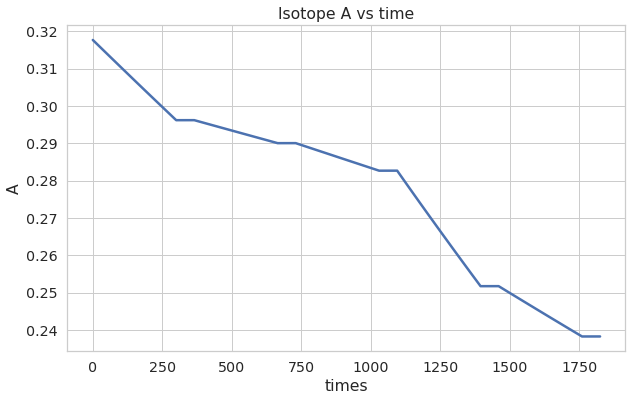

In [ ]:
#We can plot each individual isotope content vs times:
sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})

sns.lineplot(data=smpl1['A']).set(title="Isotope A vs time")

[Text(0.5, 1.0, 'Isotope J vs time')]

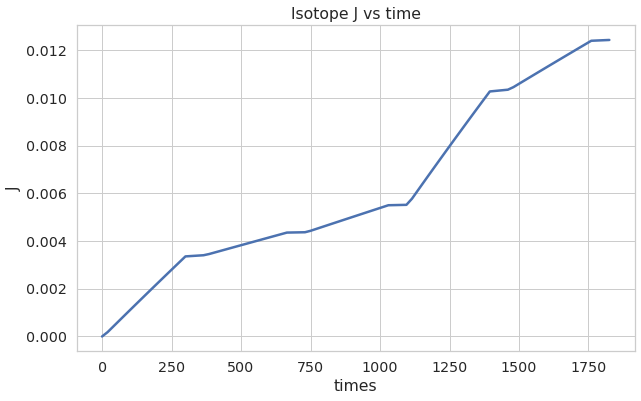

In [ ]:
sns.lineplot(data=smpl1['J']).set(title="Isotope J vs time")

[Text(0.5, 1.0, 'Input compos vs time')]

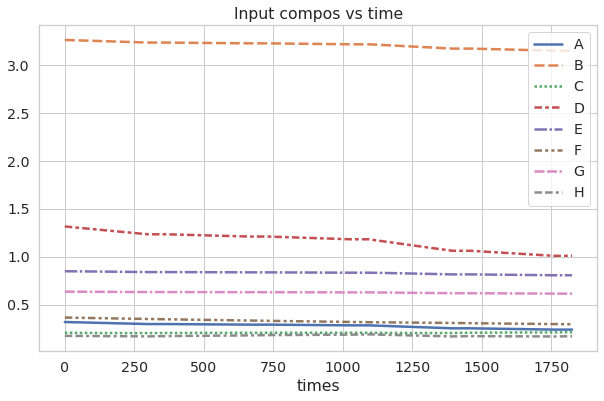

In [ ]:
#Plots reveal irradiation and maintenance cycles.

#Let's plot all input composition:
alphabet = list(string.ascii_uppercase)  # to ease the manipulation of the data

# The input compositions are isotopes A -> H  
input_compos = alphabet[:8]
sns.lineplot(data=smpl1[input_compos]).set(title="Input compos vs time")

[Text(0.5, 1.0, 'Input composition (normalized) vs time')]

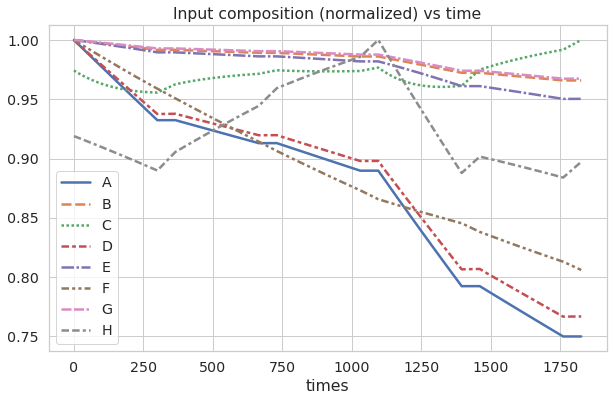

In [ ]:
#We need a data scaling to better see all the curves. Isotope B is for example much higher than the other isotopes.
smpl1_max = smpl1.max()
smpl1_norm = smpl1 / smpl1_max

sns.lineplot(data=smpl1_norm[input_compos]).set(
    title="Input composition (normalized) vs time")

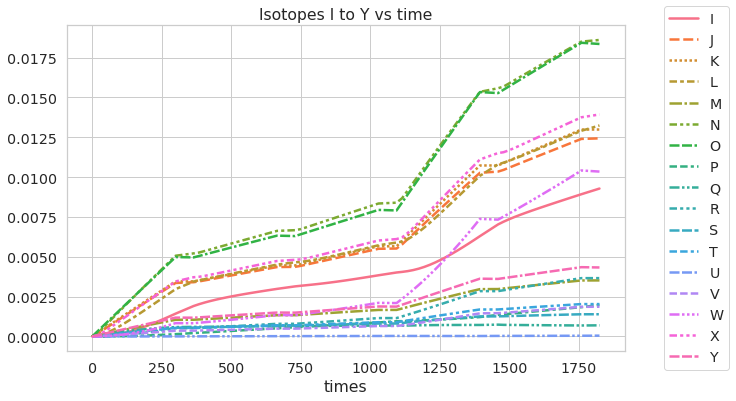

In [ ]:
#And the rest of the isotopes (except Z):
g = sns.lineplot(data=smpl1[alphabet[8: -1]])
g.set(title="Isotopes I to Y vs time")
g.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), ncol=1)

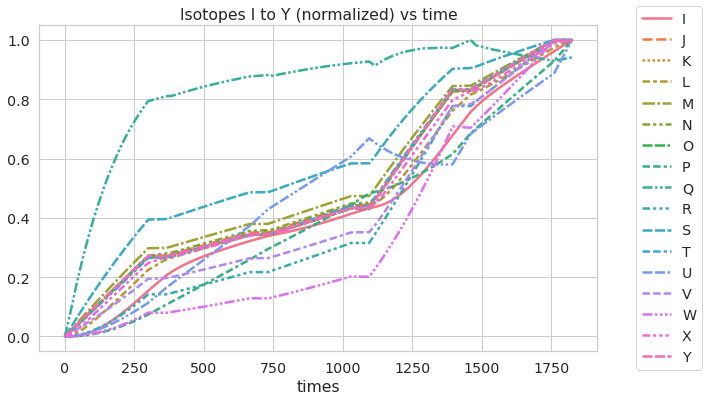

In [ ]:
#Normalized:
g = sns.lineplot(data=smpl1_norm[alphabet[8: -1]])
g.set(title="Isotopes I to Y (normalized) vs time")
g.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), ncol=1)

[Text(0.5, 1.0, 'Isotope Z vs time')]

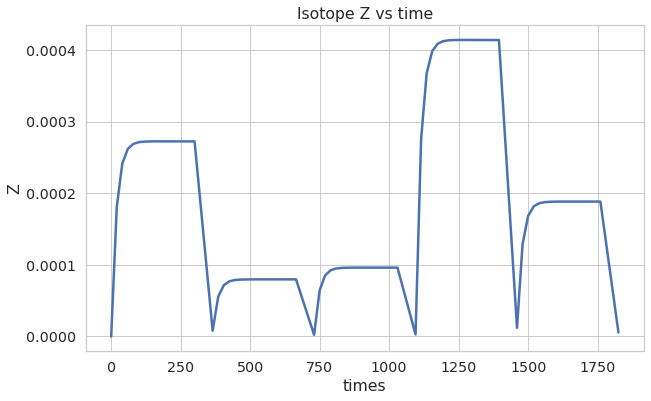

In [ ]:
#Z alone:
sns.lineplot(data=smpl1['Z']).set(title="Isotope Z vs time")

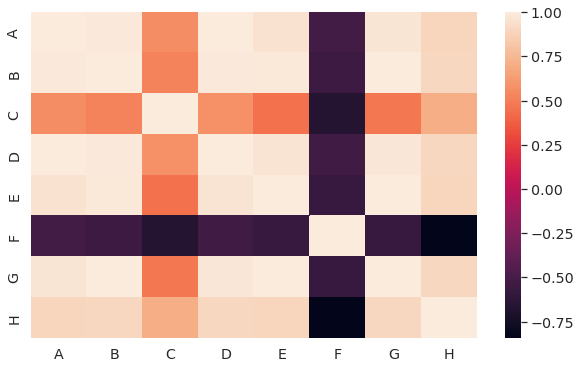

In [ ]:
#We want to see if there is a pairwise correlation between the time variation of isotopes. 
#Let's compute the first discrete difference of element and plot the heatmap of the correlation between first isotopes:
smpl1_diff = smpl1.diff()
sns.heatmap(smpl1_diff[input_compos].corr())

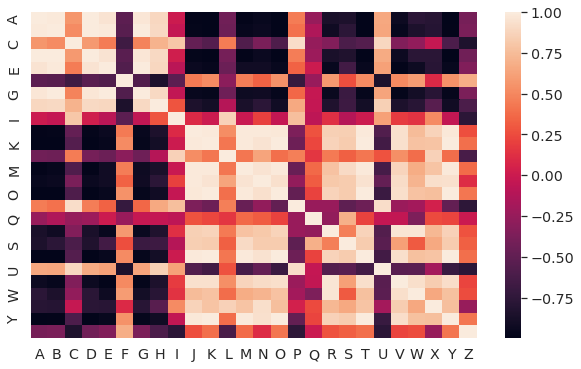

In [ ]:
#Here we see that for example A and D are positively correlated in their temporal variation (coefficient 1.00) and F and H are negatively correlated (coeff < -0.75).
#And between all isotopes:
sns.heatmap(smpl1_diff[alphabet].corr())
#It shows that the "input" isotopes that mainly decline have a strongly negative correlation in their time variation with almost all the other isotopes which are created in the five years time. Except for example for C and F which behave differently.

In [ ]:
### Input and output data
#To separate input data from output data, use the index of the dataframes or the "times" column.
#The input data for instance is composed of the value of each T=0 entry in the datasets. To obtain those values, simply select every entry having T=0 in the train or test datasets : 
dtrain.loc[0].shape  # equivalent to dtrain.loc[dtrain["times"] == 0.]

(690, 32)

In [ ]:
#As said before, the train dataset regroup a total of 690 simulations that were performed varying the 13 input parameters listed above. Here the dataset is found to have 32 parameters at T=0, but only 13 are non zero, as can be seen using :  
dtrain.iloc[0]

times    0.000000
A        0.317729
B        3.265168
C        0.205470
D        1.316402
E        0.848286
F        0.364322
G        0.635073
H        0.173054
I        0.000000
J        0.000000
K        0.000000
L        0.000000
M        0.000000
N        0.000000
O        0.000000
P        0.000000
Q        0.000000
R        0.000000
S        0.000000
T        0.000000
U        0.000000
V        0.000000
W        0.000000
X        0.000000
Y        0.000000
Z        0.000000
p1       0.023597
p2       0.006906
p3       0.008332
p4       0.035934
p5       0.016353
Name: 0, dtype: float64

In [ ]:
#As adverstised, the initial compositions for isotopes "I" -> "Z" are zero, leaving only 13 input parameters. 
#At T= 1825 days the (81th timestep), the composition has evolved :
dtrain.iloc[[0, 80]]

,times,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,p1,p2,p3,p4,p5
0,0.0,0.317729,3.265168,0.205470,1.316402,0.848286,0.364322,0.635073,0.173054,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.023597,0.006906,0.008332,0.035934,0.016353
80,1825.0,0.238300,3.153707,0.210896,1.009524,0.806160,0.293671,0.614346,0.168961,0.009283,0.012432,0.012987,0.013242,0.003518,0.018607,0.018356,0.00198,0.000699,0.003661,0.001394,0.002033,0.000051,0.001866,0.010348,0.013931,0.00433,0.000006,0.023597,0.006906,0.008332,0.035934,0.016353


In [ ]:
#To get all of the unique timesteps, one can do:
timesteps = dtrain["times"].unique()
print(timesteps)

[   0.   20.   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.
  240.  260.  280.  300.  365.  385.  405.  425.  445.  465.  485.  505.
  525.  545.  565.  585.  605.  625.  645.  665.  730.  750.  770.  790.
  810.  830.  850.  870.  890.  910.  930.  950.  970.  990. 1010. 1030.
 1095. 1115. 1135. 1155. 1175. 1195. 1215. 1235. 1255. 1275. 1295. 1315.
 1335. 1355. 1375. 1395. 1460. 1480. 1500. 1520. 1540. 1560. 1580. 1600.
 1620. 1640. 1660. 1680. 1700. 1720. 1740. 1760. 1825.]


In [ ]:
# The input parameters are composed of the input_compos + parameters p1 to p5 
input_params = input_compos + ["p1", "p2", "p3", "p4", "p5"]
input_params

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'p1', 'p2', 'p3', 'p4', 'p5']

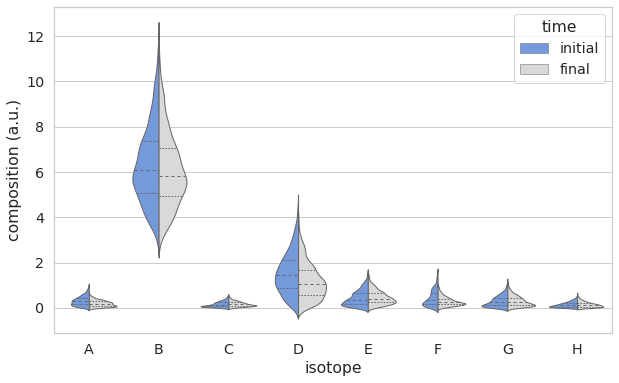

In [ ]:
## Normalization of the data
#It is important to note that the composition data that make up the database are very heterogeneous. Indeed, the isotopes present in this database __have typical compositions that can present orders of magnitude of differences__. This can pose serious problems of normalization to succeed in learning the data at best. 
#Let us for instance plot the distributions of the isotopes that makes up the input parameter composition (i.e. isotopes A to H) at the initial T=0 and final T=1825 times : 

temp_initial = pd.DataFrame(
    dtrain.loc[0, ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']].melt(
    value_name="composition (a.u.)", var_name="isotope")
)
temp_final = pd.DataFrame(
    dtrain.loc[80, ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']].melt(
    value_name="composition (a.u.)", var_name="isotope")
)
temp_initial['time'] = 'initial'
temp_final['time'] = 'final'

temp = pd.concat([temp_initial, temp_final], axis=0)

# plot a violin plot for both the initial and final compositions of the input_compos  
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5, 'figure.figsize':(14, 8)})
sns.violinplot(
    data=temp,
    x="isotope",
    y="composition (a.u.)",
    hue="time",
    split=True,
    inner="quartile",
    linewidth=1,
    palette={"initial": "cornflowerblue", "final": ".85"},
)

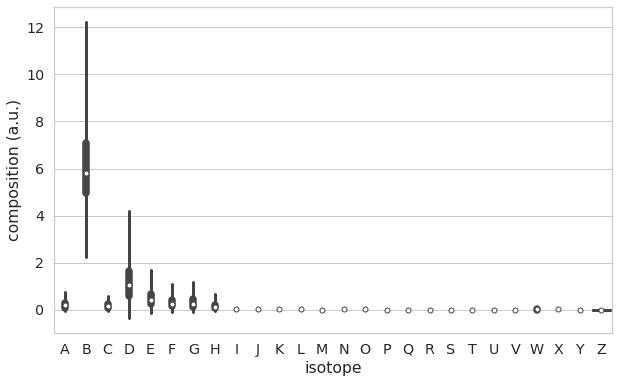

In [ ]:
#As can be seen from the figure, most matter inside the reactor is made up of isotope B. 
#The difficulty lies in the fact that we want, in the end, to have a precise __relative__ error on each individual isotope because it can happen that an isotope which is present in small quantities still has a non-negligible impact on the safety of the reactor and on the mitigation of an accident.
#So we can't just be good in the absolute overall composition of the matter: we need to be sufficiently precise for each individual isotope !__
#The differences between the isotopes for the final compositions, adding all of the 26 isotopes, is even more visible:  

temp = pd.DataFrame(
    dtrain.loc[80, alphabet].melt(
    value_name="composition (a.u.)", var_name="isotope")
)
sns.violinplot(data=temp, x="isotope", y="composition (a.u.)", inner="box")

In [ ]:
#There, we want to be sufficiently precise on each individual isotopes, even if there exist ~ up to 5 orders of magnitudes between some isotopes ! 

dtrain.B.max(), dtrain.Z.max()

(11.71932, 0.0006211064)

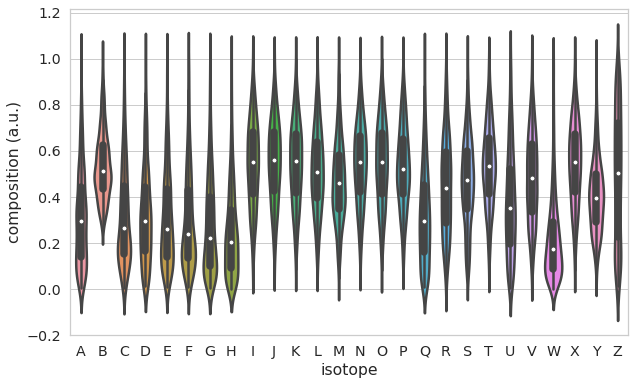

In [ ]:
#To achieve good overall performances for this challenge, it is believed that the first key is to find a clever way to normalize the input and output data.
#In this notebook, we propose to normalize data just before feeding it into the models, i.e. normalize X and Y matrices. But just to see the effect of normalization, let's visualize isotope composition at a given time step after scaling.
#You can change timestep in loc[ ] to see compositions at different times.

# dtrain at a certain timestep
temp = dtrain.loc[50, alphabet]
# scaling
temp = temp / temp.max()

temp = pd.DataFrame(
    temp.melt(
    value_name="composition (a.u.)", var_name="isotope")
)

sns.violinplot(data=temp,x="isotope",y="composition (a.u.)", inner="box")

In [ ]:
## A simple baseline algorithm  
#To benchmark the performances of a machine learning algorithm, we first try to build a simple baseline method.
#Our goal is to predict the composition of matter inside the reactor **at any given time** by just using its initial composition (isotopes A --> H) and the parameters p1, ..., p5.
#The baseline algorithm presented here simply performs a multioutput linear regression for each isotope. Here we have  80 timesteps as output in the predictive model.

#Let us first reshape the data into a form that will be more useful for the rest of this notebook 
train_data = dtrain[alphabet].add_prefix('Y_')
train_data["times"] = dtrain["times"]
train_data = train_data[ train_data["times"] > 0.]
temp = dtrain.loc[0][input_params].reset_index(drop=True)
temp = temp.loc[temp.index.repeat(80)].reset_index(drop=True)
train_data = pd.concat([temp, train_data.reset_index(drop=True)], axis=1)
train_data

test_data = dtest[alphabet].add_prefix('Y_')
test_data["times"] = dtest["times"]
test_data = test_data[test_data["times"] > 0.]
temp = dtest.loc[0][input_params].reset_index(drop=True)
temp = temp.loc[temp.index.repeat(80)].reset_index(drop=True)
test_data = pd.concat([temp, test_data.reset_index(drop=True)], axis=1)
test_data

,A,B,C,D,E,F,G,H,p1,p2,p3,p4,p5,Y_A,Y_B,Y_C,Y_D,Y_E,Y_F,Y_G,Y_H,Y_I,Y_J,Y_K,Y_L,Y_M,Y_N,Y_O,Y_P,Y_Q,Y_R,Y_S,Y_T,Y_U,Y_V,Y_W,Y_X,Y_Y,Y_Z,times
0,0.133810,4.776655,0.401556,2.131205,0.783545,0.114118,0.762691,0.140276,0.044514,0.011609,0.007466,0.002743,0.040281,0.132701,4.772421,0.399662,2.116149,0.784623,0.116937,0.761039,0.138697,0.000004,0.000349,0.000445,0.000078,0.000124,0.000409,0.000638,4.921628e-07,0.000107,0.000008,0.000074,0.000065,7.151626e-08,0.000036,0.000015,0.000145,0.000141,0.000331,20.0
1,0.133810,4.776655,0.401556,2.131205,0.783545,0.114118,0.762691,0.140276,0.044514,0.011609,0.007466,0.002743,0.040281,0.131602,4.768180,0.397866,2.101764,0.785669,0.119713,0.759411,0.137147,0.000028,0.000788,0.000890,0.000278,0.000251,0.001066,0.001275,3.042414e-06,0.000220,0.000033,0.000152,0.000131,2.741408e-07,0.000078,0.000059,0.000491,0.000282,0.000443,40.0
2,0.133810,4.776655,0.401556,2.131205,0.783545,0.114118,0.762691,0.140276,0.044514,0.011609,0.007466,0.002743,0.040281,0.130507,4.763926,0.396161,2.087453,0.786703,0.122439,0.757784,0.135616,0.000083,0.001225,0.001334,0.000563,0.000377,0.001736,0.001911,8.233230e-06,0.000317,0.000074,0.000226,0.000197,5.910356e-07,0.000122,0.000133,0.000910,0.000422,0.000481,60.0
3,0.133810,4.776655,0.401556,2.131205,0.783545,0.114118,0.762691,0.140276,0.044514,0.011609,0.007466,0.002743,0.040281,0.129422,4.759661,0.394536,2.073188,0.787729,0.125117,0.756160,0.134112,0.000173,0.001659,0.001777,0.000907,0.000500,0.002402,0.002546,1.611003e-05,0.000401,0.000128,0.000298,0.000265,1.007280e-06,0.000167,0.000233,0.001355,0.000562,0.000494,80.0
4,0.133810,4.776655,0.401556,2.131205,0.783545,0.114118,0.762691,0.140276,0.044514,0.011609,0.007466,0.002743,0.040281,0.128346,4.755396,0.392992,2.058991,0.788719,0.127751,0.754545,0.132633,0.000296,0.002092,0.002218,0.001290,0.000622,0.003065,0.003180,2.657179e-05,0.000475,0.000194,0.000368,0.000332,1.509132e-06,0.000214,0.000360,0.001807,0.000702,0.000498,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18395,0.457563,5.532067,0.350256,2.744948,0.997465,0.341679,0.141960,0.215506,0.014510,0.024052,0.035835,0.048688,0.008009,0.349419,5.362785,0.334786,2.214174,1.027648,0.302531,0.156442,0.200398,0.013778,0.018038,0.018105,0.018978,0.004058,0.026776,0.026426,2.792802e-03,0.001637,0.004523,0.002202,0.002959,9.559488e-05,0.002450,0.004512,0.020048,0.006538,0.000094,1700.0
18396,0.457563,5.532067,0.350256,2.744948,0.997465,0.341679,0.141960,0.215506,0.014510,0.024052,0.035835,0.048688,0.008009,0.349006,5.362041,0.334873,2.212055,1.027713,0.301910,0.156495,0.200820,0.013851,0.018107,0.018177,0.019053,0.004072,0.026876,0.026507,2.849838e-03,0.001635,0.004550,0.002206,0.002970,9.788469e-05,0.002462,0.004540,0.020128,0.006558,0.000094,1720.0
18397,0.457563,5.532067,0.350256,2.744948,0.997465,0.341679,0.141960,0.215506,0.014510,0.024052,0.035835,0.048688,0.008009,0.348592,5.361306,0.334943,2.209939,1.027774,0.301292,0.156549,0.201237,0.013922,0.018177,0.018249,0.019128,0.004087,0.026976,0.026588,2.906235e-03,0.001633,0.004576,0.002211,0.002982,1.001580e-04,0.002474,0.004568,0.020208,0.006578,0.000094,1740.0
18398,0.457563,5.532067,0.350256,2.744948,0.997465,0.341679,0.141960,0.215506,0.014510,0.024052,0.035835,0.048688,0.008009,0.348177,5.360567,0.334995,2.207827,1.027837,0.300674,0.156603,0.201652,0.013989,0.018246,0.018321,0.019203,0.004101,0.027076,0.026668,2.961929e-03,0.001632,0.004602,0.002215,0.002994,1.024140e-04,0.002485,0.004597,0.020288,0.006597,0.000094,1760.0


In [ ]:
### Train and test data:
#From these dataframe, let us extract X_train, y_train, X_test and y_test for each isotope:

#For isotope A:
train_target_A = train_data.groupby(input_params)['Y_A'].apply(list).apply(pd.Series).rename(
    columns=lambda x: 'A' + str(x + 1)).reset_index()
train_target_A

,A,B,C,D,E,F,G,H,p1,p2,p3,p4,p5,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,...,A41,A42,A43,A44,A45,A46,A47,A48,A49,A50,A51,A52,A53,A54,A55,A56,A57,A58,A59,A60,A61,A62,A63,A64,A65,A66,A67,A68,A69,A70,A71,A72,A73,A74,A75,A76,A77,A78,A79,A80
0,0.005192,4.990765,0.126878,2.347393,0.315230,0.374373,0.078563,0.129959,0.027372,0.022840,0.002370,0.019275,0.041492,0.005172,0.005151,0.005131,0.005112,0.005092,0.005073,0.005055,0.005036,0.005018,0.005000,0.004982,0.004965,0.004947,0.004930,0.004914,0.004925,0.004912,0.004900,0.004888,0.004876,0.004865,0.004853,0.004842,0.004831,0.004820,0.004809,0.004799,...,0.004788,0.004790,0.004792,0.004794,0.004797,0.004799,0.004801,0.004812,0.004808,0.004804,0.004801,0.004798,0.004795,0.004792,0.004789,0.004786,0.004783,0.004781,0.004779,0.004777,0.004775,0.004773,0.004771,0.004781,0.004775,0.004769,0.004763,0.004757,0.004751,0.004745,0.004739,0.004734,0.004728,0.004722,0.004716,0.004711,0.004705,0.004700,0.004694,0.004703
1,0.006727,4.876231,0.174605,3.000470,0.931660,0.317459,0.026470,0.110730,0.020134,0.012753,0.004577,0.014281,0.046835,0.006711,0.006696,0.006681,0.006666,0.006652,0.006638,0.006624,0.006610,0.006597,0.006583,0.006570,0.006558,0.006545,0.006533,0.006521,0.006535,0.006530,0.006525,0.006520,0.006515,0.006510,0.006505,0.006501,0.006496,0.006492,0.006488,0.006484,...,0.006501,0.006503,0.006505,0.006508,0.006510,0.006512,0.006515,0.006529,0.006528,0.006527,0.006526,0.006526,0.006525,0.006525,0.006524,0.006524,0.006524,0.006524,0.006524,0.006524,0.006525,0.006525,0.006526,0.006539,0.006533,0.006527,0.006522,0.006515,0.006510,0.006504,0.006498,0.006491,0.006485,0.006479,0.006473,0.006467,0.006461,0.006456,0.006449,0.006461
2,0.007188,6.176172,0.109065,1.556984,0.296715,0.204958,0.154517,0.026233,0.027025,0.020994,0.018834,0.028136,0.044406,0.007146,0.007104,0.007062,0.007022,0.006981,0.006941,0.006901,0.006862,0.006823,0.006784,0.006746,0.006708,0.006670,0.006633,0.006596,0.006603,0.006576,0.006550,0.006523,0.006497,0.006471,0.006445,0.006419,0.006394,0.006369,0.006344,0.006319,...,0.006054,0.006035,0.006016,0.005998,0.005980,0.005962,0.005944,0.005951,0.005924,0.005898,0.005872,0.005846,0.005821,0.005796,0.005771,0.005746,0.005721,0.005697,0.005673,0.005649,0.005625,0.005601,0.005578,0.005583,0.005547,0.005511,0.005475,0.005439,0.005403,0.005368,0.005332,0.005297,0.005262,0.005228,0.005193,0.005158,0.005124,0.005089,0.005055,0.005060
3,0.008880,4.154490,0.077639,3.082386,0.109124,0.401981,0.252849,0.127539,0.016481,0.008402,0.047417,0.028603,0.016192,0.008863,0.008847,0.008830,0.008814,0.008798,0.008782,0.008766,0.008750,0.008734,0.008718,0.008702,0.008686,0.008670,0.008655,0.008639,0.008654,0.008649,0.008643,0.008638,0.008633,0.008627,0.008622,0.008617,0.008611,0.008606,0.008601,0.008596,...,0.008159,0.008112,0.008066,0.008019,0.007973,0.007927,0.007881,0.007894,0.007869,0.007843,0.007818,0.007793,0.007768,0.007743,0.007718,0.007693,0.007669,0.007645,0.007620,0.007596,0.007572,0.007548,0.007524,0.007537,0.007526,0.007514,0.007503,0.007492,0.007481,0.007470,0.007459,0.007448,0.007438,0.007427,0.007416,0.007406,0.007395,0.007385,0.007375,0.007387
4,0.011813,5.558284,0.438273,2.416261,0.662015,0.691550,0.417485,0.031835,0.017720,0.038619,0.023864,0.035516,0.043880,0.011788,0.011763,0.011739,0.011715,0.011692,0.011670,0.011648,0.011626,0.011605,0.011584,0.011563,0.011543,0.011524,0.011505,0.011487,0.011498,0.011458,0.011418,0.011379,0.011341,0.011304,0.011267,0.011231,0.011195,0.011161,0.011127,0.011094,...,0.010858,0.010847,0.010836,0.010825,0.010815,0.010805,0.010796,0.010806,0.010794,0.010782,0.010770,0.010759,0.010747,0.010737,0.010728,0.010718,0.010708,0.010699,0.010691,0.010682,0.010674,0.010666,0.010659,0.010669,0.010662,0.010656,0.010651,0.010645,0.010641,0.010636,0.010632,0.010628,0.010623,0.010618,0.010616,0.010612,0.010609,0.010605,0.010602,0.010611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
test_target_A = test_data.groupby(input_params)['Y_A'].apply(list).apply(pd.Series).rename(
    columns=lambda x: 'A' + str(x + 1)).reset_index()
test_target_A

,A,B,C,D,E,F,G,H,p1,p2,p3,p4,p5,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,...,A41,A42,A43,A44,A45,A46,A47,A48,A49,A50,A51,A52,A53,A54,A55,A56,A57,A58,A59,A60,A61,A62,A63,A64,A65,A66,A67,A68,A69,A70,A71,A72,A73,A74,A75,A76,A77,A78,A79,A80
0,0.007282,5.636715,0.412482,2.093307,1.554593,1.225205,0.175682,0.049742,0.045963,0.026232,0.043233,0.028797,0.029370,0.007246,0.007210,0.007175,0.007142,0.007109,0.007077,0.007046,0.007016,0.006987,0.006958,0.006931,0.006905,0.006879,0.006854,0.006830,0.006840,0.006829,0.006819,0.006810,0.006800,0.006792,0.006783,0.006775,0.006768,0.006761,0.006754,0.006748,...,0.006695,0.006692,0.006691,0.006690,0.006688,0.006688,0.006688,0.006697,0.006699,0.006702,0.006706,0.006709,0.006714,0.006718,0.006723,0.006727,0.006733,0.006739,0.006745,0.006752,0.006759,0.006766,0.006773,0.006782,0.006791,0.006801,0.006810,0.006820,0.006830,0.006840,0.006851,0.006862,0.006874,0.006886,0.006898,0.006909,0.006922,0.006935,0.006947,0.006956
1,0.018082,4.220983,0.253170,1.590942,0.582395,1.075491,0.570636,0.130346,0.009426,0.001281,0.034682,0.043967,0.048110,0.018060,0.018038,0.018016,0.017994,0.017972,0.017951,0.017929,0.017908,0.017886,0.017865,0.017844,0.017823,0.017803,0.017782,0.017761,0.017769,0.017769,0.017768,0.017767,0.017767,0.017766,0.017766,0.017765,0.017765,0.017764,0.017764,0.017763,...,0.017136,0.017067,0.016999,0.016931,0.016863,0.016796,0.016728,0.016736,0.016652,0.016569,0.016486,0.016404,0.016323,0.016241,0.016160,0.016079,0.015998,0.015918,0.015838,0.015759,0.015679,0.015601,0.015522,0.015529,0.015445,0.015362,0.015280,0.015197,0.015115,0.015033,0.014952,0.014871,0.014790,0.014710,0.014631,0.014551,0.014472,0.014393,0.014316,0.014322
2,0.018187,8.435444,0.017857,0.118998,0.031198,0.009453,0.007955,0.009778,0.046906,0.001916,0.007768,0.019469,0.020830,0.017000,0.015852,0.014747,0.013688,0.012674,0.011708,0.010791,0.009925,0.009110,0.008346,0.007631,0.006966,0.006348,0.005776,0.005248,0.005248,0.005228,0.005208,0.005188,0.005168,0.005148,0.005128,0.005108,0.005088,0.005068,0.005048,0.005029,...,0.004283,0.004214,0.004146,0.004079,0.004013,0.003948,0.003884,0.003884,0.003728,0.003577,0.003432,0.003292,0.003157,0.003028,0.002904,0.002785,0.002670,0.002560,0.002455,0.002353,0.002256,0.002163,0.002073,0.002073,0.001982,0.001894,0.001810,0.001730,0.001653,0.001580,0.001510,0.001443,0.001380,0.001319,0.001260,0.001205,0.001152,0.001101,0.001053,0.001053
3,0.024323,7.804812,0.109733,0.485782,0.370916,0.187885,0.122907,0.108180,0.045575,0.039759,0.048395,0.035755,0.007074,0.023882,0.023448,0.023021,0.022600,0.022186,0.021779,0.021378,0.020984,0.020595,0.020213,0.019837,0.019466,0.019100,0.018740,0.018387,0.018389,0.018087,0.017789,0.017495,0.017205,0.016918,0.016636,0.016358,0.016083,0.015813,0.015546,0.015282,...,0.011781,0.011529,0.011280,0.011037,0.010798,0.010563,0.010332,0.010334,0.010168,0.010004,0.009843,0.009685,0.009528,0.009374,0.009222,0.009073,0.008926,0.008781,0.008639,0.008498,0.008360,0.008223,0.008089,0.008090,0.008065,0.008039,0.008014,0.007988,0.007963,0.007939,0.007914,0.007889,0.007865,0.007841,0.007817,0.007793,0.007769,0.007746,0.007722,0.007723
4,0.027303,3.948096,0.222217,1.507915,0.348863,1.006527,0.345910,0.118197,0.003194,0.031200,0.046299,0.016525,0.027422,0.027292,0.027281,0.027270,0.027259,0.027248,0.027237,0.027226,0.027215,0.027204,0.027194,0.027183,0.027172,0.027161,0.027151,0.027140,0.027148,0.027025,0.026902,0.026780,0.026658,0.026537,0.026416,0.026295,0.026175,0.026055,0.025935,0.025816,...,0.023809,0.023640,0.023472,0.023305,0.023138,0.022972,0.022807,0.022813,0.022756,0.022700,0.022643,0.022587,0.022531,0.022475,0.022419,0.022363,0.022308,0.022253,0.022198,0.022143,0.022089,0.022034,0.021980,0.021986,0.021896,0.021807,0.021718,0.021629,0.021541,0.021453,0.021365,0.021278,0.021191,0.021105,0.021018,0.020933,0.020847,0.020762,0.020677,0.020683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
X_train = train_target_A[input_params]
# scale X_train
max_X_train = X_train.max()
X_train = X_train / max_X_train
X_train

,A,B,C,D,E,F,G,H,p1,p2,p3,p4,p5
0,0.005363,0.425858,0.233685,0.519969,0.206268,0.241581,0.067691,0.240884,0.547926,0.458792,0.047443,0.385955,0.832317
1,0.006949,0.416085,0.321590,0.664632,0.609623,0.204855,0.022807,0.205243,0.403038,0.256179,0.091628,0.285955,0.939493
2,0.007425,0.527008,0.200877,0.344886,0.194153,0.132258,0.133134,0.048624,0.540978,0.421714,0.377074,0.563385,0.890780
3,0.009173,0.354499,0.142997,0.682777,0.071404,0.259396,0.217858,0.236398,0.329918,0.168780,0.949347,0.572730,0.324807
4,0.012203,0.474284,0.807217,0.535224,0.433183,0.446254,0.359711,0.059008,0.354717,0.775757,0.477787,0.711153,0.880216
...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0.934802,0.839271,0.190380,0.135012,0.209862,0.015606,0.142126,0.159681,0.504507,0.883250,0.142299,0.711716,0.454782
686,0.965438,0.807748,0.049772,0.085232,0.090867,0.146050,0.001817,0.140511,0.853211,0.871958,0.175744,0.545873,0.418075
687,0.988886,0.871562,0.015433,0.024641,0.001011,0.002283,0.013307,0.003028,0.275266,0.755523,0.489252,0.128342,0.622672
688,0.991432,0.858156,0.205763,0.145320,0.044407,0.069396,0.166487,0.025618,0.596790,0.681584,0.732292,0.825660,0.488552


In [ ]:
y_train_A = train_target_A.iloc[:, len(input_params):]
# scale y_train_A
max_y_train_A = y_train_A.max()
y_train_A = y_train_A / max_y_train_A
y_train_A

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,A29,A30,A31,A32,A33,A34,A35,A36,A37,A38,A39,A40,A41,A42,A43,A44,A45,A46,A47,A48,A49,A50,A51,A52,A53,A54,A55,A56,A57,A58,A59,A60,A61,A62,A63,A64,A65,A66,A67,A68,A69,A70,A71,A72,A73,A74,A75,A76,A77,A78,A79,A80
0,0.005417,0.005439,0.005448,0.005457,0.005466,0.005475,0.005485,0.005495,0.005505,0.005516,0.005527,0.005538,0.005550,0.005562,0.005574,0.005587,0.005660,0.005734,0.005788,0.005823,0.005855,0.005860,0.005865,0.005870,0.005876,0.005882,0.005888,0.005894,0.005901,0.005908,0.005915,0.005928,0.005938,0.005947,0.005957,0.005967,0.005977,0.005986,0.005996,0.006006,0.006016,0.006026,0.006036,0.006046,0.006057,0.006067,0.006077,0.006090,0.006150,0.006210,0.006272,0.006335,0.006400,0.006465,0.006532,0.006600,0.006670,0.006741,0.006814,0.006888,0.006964,0.007041,0.007120,0.007135,0.007131,0.007127,0.007124,0.007120,0.007117,0.007114,0.007110,0.007107,0.007104,0.007101,0.007097,0.007094,0.007091,0.007089,0.007085,0.007099
1,0.007030,0.007071,0.007093,0.007116,0.007139,0.007163,0.007187,0.007212,0.007237,0.007263,0.007289,0.007315,0.007342,0.007369,0.007397,0.007414,0.007523,0.007635,0.007720,0.007779,0.007834,0.007854,0.007874,0.007894,0.007914,0.007935,0.007956,0.007977,0.007998,0.008019,0.008041,0.008059,0.008071,0.008083,0.008095,0.008107,0.008119,0.008131,0.008144,0.008156,0.008169,0.008182,0.008194,0.008207,0.008220,0.008233,0.008246,0.008264,0.008350,0.008437,0.008526,0.008616,0.008709,0.008803,0.008899,0.008997,0.009097,0.009199,0.009303,0.009409,0.009517,0.009627,0.009739,0.009760,0.009758,0.009756,0.009755,0.009753,0.009752,0.009750,0.009748,0.009746,0.009744,0.009742,0.009740,0.009739,0.009737,0.009736,0.009734,0.009752
2,0.007485,0.007501,0.007498,0.007495,0.007492,0.007490,0.007488,0.007486,0.007485,0.007484,0.007483,0.007483,0.007482,0.007483,0.007483,0.007491,0.007577,0.007664,0.007725,0.007758,0.007787,0.007781,0.007775,0.007769,0.007764,0.007758,0.007753,0.007748,0.007744,0.007739,0.007735,0.007743,0.007727,0.007712,0.007696,0.007681,0.007665,0.007650,0.007636,0.007621,0.007607,0.007593,0.007578,0.007565,0.007551,0.007538,0.007524,0.007532,0.007578,0.007624,0.007671,0.007719,0.007769,0.007820,0.007871,0.007924,0.007978,0.008033,0.008089,0.008146,0.008204,0.008264,0.008324,0.008333,0.008285,0.008237,0.008189,0.008142,0.008094,0.008047,0.008000,0.007953,0.007906,0.007860,0.007814,0.007768,0.007722,0.007676,0.007630,0.007637
3,0.009284,0.009342,0.009375,0.009409,0.009442,0.009477,0.009511,0.009546,0.009582,0.009617,0.009653,0.009690,0.009726,0.009763,0.009801,0.009818,0.009964,0.010114,0.010229,0.010308,0.010383,0.010410,0.010437,0.010464,0.010491,0.010519,0.010547,0.010575,0.010603,0.010631,0.010660,0.010678,0.010631,0.010583,0.010535,0.010488,0.010441,0.010394,0.010347,0.010300,0.010253,0.010206,0.010160,0.010113,0.010067,0.010021,0.009975,0.009992,0.010064,0.010138,0.010213,0.010290,0.010367,0.010447,0.010527,0.010610,0.010693,0.010779,0.010866,0.010954,0.011045,0.011136,0.011230,0.011248,0.011240,0.011232,0.011223,0.011215,0.011207,0.011198,0.011191,0.011183,0.011175,0.011167,0.011160,0.011152,0.011145,0.011138,0.011131,0.011149
4,0.012348,0.012421,0.012463,0.012506,0.012549,0.012593,0.012639,0.012685,0.012731,0.012779,0.012828,0.012877,0.012927,0.012979,0.013031,0.013044,0.013200,0.013361,0.013475,0.013542,0.013603,0.013603,0.013602,0.013604,0.013606,0.013608,0.013612,0.013615,0.013621,0.013627,0.013634,0.013647,0.013644,0.013643,0.013641,0.013640,0.013640,0.013640,0.013641,0.013643,0.013644,0.013646,0.013649,0.013652,0.013656,0.013660,0.013665,0.013678,0.013806,0.013936,0.014069,0.014206,0.014344,0.014487,0.014633,0.014780,0.014931,0.015086,0.015244,0.015405,0.015569,0.015736,0.015908,0.015922,0.015924,0.015927,0.015932,0.015935,0.015941,0.015945,0.015950,0.015956,0.015961,0.015966,0.015974,0.015981,0.015988,0.015995,0.016003,0.016016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
X_test = test_target_A[input_params]
# scale X_test the same way X_train was scaled
X_test = X_test / max_X_train
X_test

,A,B,C,D,E,F,G,H,p1,p2,p3,p4,p5
0,0.007523,0.480976,0.759716,0.463687,1.017233,0.790619,0.151370,0.092199,0.920067,0.526934,0.865575,0.576617,0.589161
1,0.018679,0.360173,0.466292,0.352408,0.381084,0.694009,0.491669,0.241601,0.188677,0.025735,0.694389,0.880378,0.965078
2,0.018788,0.719790,0.032890,0.026359,0.020414,0.006100,0.006854,0.018124,0.938942,0.038497,0.155534,0.389847,0.417847
3,0.025126,0.665978,0.202108,0.107605,0.242705,0.121241,0.105899,0.200516,0.912311,0.798647,0.968925,0.715934,0.141899
4,0.028204,0.336888,0.409283,0.334017,0.228275,0.649507,0.298041,0.219083,0.063933,0.626713,0.926961,0.330878,0.550075
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,0.906787,0.863638,0.104482,0.135840,0.018051,0.126131,0.023140,0.039094,0.455852,0.109425,0.350386,0.631457,0.897085
226,0.926902,0.853662,0.051338,0.041312,0.031836,0.054126,0.033461,0.057822,0.808922,0.836620,0.093961,0.718253,0.763929
227,0.946463,0.885974,0.013861,0.008394,0.014885,0.010305,0.007510,0.001265,0.487485,0.871916,0.895170,0.351277,0.484065
228,1.004813,0.843915,0.054957,0.052099,0.033377,0.036635,0.032555,0.032586,0.186215,0.364629,0.702929,0.035355,0.676715


In [ ]:
y_test_A = test_target_A.iloc[:, len(input_params):]
y_test_A

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,A29,A30,A31,A32,A33,A34,A35,A36,A37,A38,A39,A40,A41,A42,A43,A44,A45,A46,A47,A48,A49,A50,A51,A52,A53,A54,A55,A56,A57,A58,A59,A60,A61,A62,A63,A64,A65,A66,A67,A68,A69,A70,A71,A72,A73,A74,A75,A76,A77,A78,A79,A80
0,0.007246,0.007210,0.007175,0.007142,0.007109,0.007077,0.007046,0.007016,0.006987,0.006958,0.006931,0.006905,0.006879,0.006854,0.006830,0.006840,0.006829,0.006819,0.006810,0.006800,0.006792,0.006783,0.006775,0.006768,0.006761,0.006754,0.006748,0.006742,0.006736,0.006731,0.006726,0.006736,0.006729,0.006723,0.006718,0.006713,0.006709,0.006705,0.006701,0.006698,0.006695,0.006692,0.006691,0.006690,0.006688,0.006688,0.006688,0.006697,0.006699,0.006702,0.006706,0.006709,0.006714,0.006718,0.006723,0.006727,0.006733,0.006739,0.006745,0.006752,0.006759,0.006766,0.006773,0.006782,0.006791,0.006801,0.006810,0.006820,0.006830,0.006840,0.006851,0.006862,0.006874,0.006886,0.006898,0.006909,0.006922,0.006935,0.006947,0.006956
1,0.018060,0.018038,0.018016,0.017994,0.017972,0.017951,0.017929,0.017908,0.017886,0.017865,0.017844,0.017823,0.017803,0.017782,0.017761,0.017769,0.017769,0.017768,0.017767,0.017767,0.017766,0.017766,0.017765,0.017765,0.017764,0.017764,0.017763,0.017763,0.017762,0.017762,0.017762,0.017769,0.017698,0.017626,0.017555,0.017485,0.017414,0.017344,0.017274,0.017205,0.017136,0.017067,0.016999,0.016931,0.016863,0.016796,0.016728,0.016736,0.016652,0.016569,0.016486,0.016404,0.016323,0.016241,0.016160,0.016079,0.015998,0.015918,0.015838,0.015759,0.015679,0.015601,0.015522,0.015529,0.015445,0.015362,0.015280,0.015197,0.015115,0.015033,0.014952,0.014871,0.014790,0.014710,0.014631,0.014551,0.014472,0.014393,0.014316,0.014322
2,0.017000,0.015852,0.014747,0.013688,0.012674,0.011708,0.010791,0.009925,0.009110,0.008346,0.007631,0.006966,0.006348,0.005776,0.005248,0.005248,0.005228,0.005208,0.005188,0.005168,0.005148,0.005128,0.005108,0.005088,0.005068,0.005048,0.005029,0.005009,0.004990,0.004970,0.004951,0.004951,0.004872,0.004795,0.004719,0.004643,0.004569,0.004496,0.004424,0.004353,0.004283,0.004214,0.004146,0.004079,0.004013,0.003948,0.003884,0.003884,0.003728,0.003577,0.003432,0.003292,0.003157,0.003028,0.002904,0.002785,0.002670,0.002560,0.002455,0.002353,0.002256,0.002163,0.002073,0.002073,0.001982,0.001894,0.001810,0.001730,0.001653,0.001580,0.001510,0.001443,0.001380,0.001319,0.001260,0.001205,0.001152,0.001101,0.001053,0.001053
3,0.023882,0.023448,0.023021,0.022600,0.022186,0.021779,0.021378,0.020984,0.020595,0.020213,0.019837,0.019466,0.019100,0.018740,0.018387,0.018389,0.018087,0.017789,0.017495,0.017205,0.016918,0.016636,0.016358,0.016083,0.015813,0.015546,0.015282,0.015023,0.014767,0.014515,0.014266,0.014267,0.013971,0.013681,0.013395,0.013114,0.012838,0.012567,0.012301,0.012039,0.011781,0.011529,0.011280,0.011037,0.010798,0.010563,0.010332,0.010334,0.010168,0.010004,0.009843,0.009685,0.009528,0.009374,0.009222,0.009073,0.008926,0.008781,0.008639,0.008498,0.008360,0.008223,0.008089,0.008090,0.008065,0.008039,0.008014,0.007988,0.007963,0.007939,0.007914,0.007889,0.007865,0.007841,0.007817,0.007793,0.007769,0.007746,0.007722,0.007723
4,0.027292,0.027281,0.027270,0.027259,0.027248,0.027237,0.027226,0.027215,0.027204,0.027194,0.027183,0.027172,0.027161,0.027151,0.027140,0.027148,0.027025,0.026902,0.026780,0.026658,0.026537,0.026416,0.026295,0.026175,0.026055,0.025935,0.025816,0.025697,0.025578,0.025460,0.025342,0.025350,0.025176,0.025003,0.024831,0.024659,0.024488,0.024318,0.024147,0.023978,0.023809,0.023640,0.023472,0.023305,0.023138,0.022972,0.022807,0.022813,0.022756,0.022700,0.022643,0.022587,0.022531,0.022475,0.022419,0.022363,0.022308,0.022253,0.022198,0.022143,0.022089,0.022034,0.021980,0.021986,0.021896,0.021807,0.021718,0.021629,0.021541,0.021453,0.021365,0.021278,0.021191,0.021105,0.021018,0.020933,0.020847,0.020762,0.020677,0.020683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
##We can now apply a multioutput algorithm:
model = LinearRegression()
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=57)
scores = cross_val_score(model, X_train, y_train_A, cv=cv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
errors = -scores
print(errors)
print(errors.mean())

[0.25346852 0.20156435 0.21988226 0.17279623 0.14846828 0.23597558
 0.16959568 0.22835256 0.20292559 0.26815275]
0.21011817948222147


In [ ]:
model.fit(X_train, y_train_A)
y_pred_A = model.predict(X_test)
y_pred_A = pd.DataFrame(y_pred_A, columns=y_train_A.columns) * max_y_train_A
y_pred_A

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,A29,A30,A31,A32,A33,A34,A35,A36,A37,A38,A39,A40,A41,A42,A43,A44,A45,A46,A47,A48,A49,A50,A51,A52,A53,A54,A55,A56,A57,A58,A59,A60,A61,A62,A63,A64,A65,A66,A67,A68,A69,A70,A71,A72,A73,A74,A75,A76,A77,A78,A79,A80
0,0.006891,0.006502,0.006115,0.005730,0.005347,0.004967,0.004588,0.004212,0.003837,0.003464,0.003094,0.002724,0.002357,0.001992,0.001629,0.001639,0.002555,0.003465,0.004367,0.005261,0.006147,0.007026,0.007897,0.008759,0.009614,0.010460,0.011298,0.012128,0.012949,0.013762,0.014567,0.014576,0.014561,0.014544,0.014526,0.014505,0.014482,0.014456,0.014428,0.014398,0.014366,0.014331,0.014294,0.014254,0.014212,0.014167,0.014119,0.014127,0.015013,0.015889,0.016753,0.017604,0.018444,0.019272,0.020087,0.020891,0.021682,0.022461,0.023227,0.023980,0.024721,0.025449,0.026165,0.026173,0.026816,0.027450,0.028075,0.028690,0.029296,0.029891,0.030477,0.031052,0.031618,0.032173,0.032719,0.033255,0.033780,0.034296,0.034801,0.034810
1,0.019652,0.021211,0.022758,0.024294,0.025817,0.027329,0.028829,0.030318,0.031795,0.033260,0.034714,0.036157,0.037587,0.039006,0.040414,0.040421,0.042486,0.044535,0.046565,0.048578,0.050572,0.052548,0.054505,0.056444,0.058365,0.060267,0.062150,0.064015,0.065861,0.067689,0.069499,0.069507,0.069080,0.068652,0.068224,0.067794,0.067363,0.066931,0.066499,0.066066,0.065632,0.065198,0.064762,0.064326,0.063889,0.063453,0.063015,0.063022,0.062129,0.061236,0.060344,0.059453,0.058563,0.057676,0.056790,0.055906,0.055024,0.054145,0.053267,0.052393,0.051522,0.050654,0.049789,0.049796,0.048743,0.047696,0.046658,0.045627,0.044604,0.043589,0.042582,0.041583,0.040592,0.039609,0.038634,0.037667,0.036709,0.035758,0.034816,0.034822
2,0.014498,0.010851,0.007249,0.003691,0.000176,-0.003295,-0.006725,-0.010113,-0.013459,-0.016765,-0.020029,-0.023252,-0.026434,-0.029575,-0.032677,-0.032677,-0.032707,-0.032727,-0.032735,-0.032731,-0.032716,-0.032688,-0.032649,-0.032598,-0.032536,-0.032462,-0.032376,-0.032278,-0.032169,-0.032048,-0.031915,-0.031915,-0.032331,-0.032731,-0.033114,-0.033480,-0.033829,-0.034162,-0.034479,-0.034780,-0.035066,-0.035335,-0.035590,-0.035829,-0.036054,-0.036265,-0.036461,-0.036461,-0.037382,-0.038284,-0.039164,-0.040023,-0.040860,-0.041676,-0.042472,-0.043246,-0.044001,-0.044735,-0.045449,-0.046143,-0.046819,-0.047476,-0.048113,-0.048113,-0.048746,-0.049363,-0.049962,-0.050542,-0.051104,-0.051648,-0.052174,-0.052683,-0.053174,-0.053648,-0.054105,-0.054544,-0.054968,-0.055374,-0.055763,-0.055763
3,0.021342,0.018394,0.015486,0.012614,0.009777,0.006976,0.004210,0.001478,-0.001219,-0.003883,-0.006513,-0.009110,-0.011672,-0.014201,-0.016698,-0.016696,-0.018701,-0.020685,-0.022647,-0.024585,-0.026500,-0.028392,-0.030261,-0.032107,-0.033930,-0.035729,-0.037504,-0.039256,-0.040985,-0.042689,-0.044371,-0.044369,-0.046539,-0.048685,-0.050804,-0.052897,-0.054964,-0.057005,-0.059020,-0.061010,-0.062973,-0.064911,-0.066823,-0.068710,-0.070573,-0.072410,-0.074222,-0.074222,-0.075453,-0.076662,-0.077845,-0.079003,-0.080135,-0.081242,-0.082325,-0.083383,-0.084417,-0.085427,-0.086413,-0.087377,-0.088318,-0.089237,-0.090134,-0.090134,-0.089481,-0.088823,-0.088159,-0.087489,-0.086813,-0.086132,-0.085446,-0.084755,-0.084059,-0.083360,-0.082655,-0.081947,-0.081235,-0.080519,-0.079800,-0.079800
4,0.029087,0.030858,0.032614,0.034356,0.036084,0.037798,0.039498,0.041184,0.042856,0.044514,0.046158,0.047788,0.049404,0.051006,0.052595,0.052603,0.052560,0.052515,0.052465,0.052411,0.052353,0.052292,0.052227,0.052159,0.052087,0.052012,0.051934,0.051851,0.051767,0.051679,0.051588,0.051595,0.050452,0.049313,0.048178,0.047048,0.045922,0.044801,0.043685,0.042575,0.041469,0.040369,0.039274,0.038184,0.037100,0.036022,0.034949,0.034956,0.035625,0.036286,0.036937,0.037580,0.038215,0.038839,0.039456,0.040063,0.040663,0.041253,0.041835,0.042409,0.042975,0.043532,0.044081,0.044087,0.043945,0.043804,0.043664,0.043526,0.043388,0.043251,0.043116,0.042981,0.0

In [ ]:
MAPE = mean_absolute_percentage_error(y_test_A, y_pred_A)
print(f"MAPE={MAPE:.4f}")

MAPE=0.3392


In [ ]:
##Treating all isotopes at once:
y_train_all = []
for i in alphabet:
    y_train_all.append(
        train_data.groupby(input_params)['Y_'+i].apply(list).apply(pd.Series).rename(
        columns=lambda x: i + str(x + 1)).reset_index().iloc[:, len(input_params):]
    )
    
y_train_all = pd.concat(y_train_all, axis=1)
# scale y_train_all
max_y_train_all = y_train_all.max()
y_train_all = y_train_all / max_y_train_all
y_train_all

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,A29,A30,A31,A32,A33,A34,A35,A36,A37,A38,A39,A40,...,Z41,Z42,Z43,Z44,Z45,Z46,Z47,Z48,Z49,Z50,Z51,Z52,Z53,Z54,Z55,Z56,Z57,Z58,Z59,Z60,Z61,Z62,Z63,Z64,Z65,Z66,Z67,Z68,Z69,Z70,Z71,Z72,Z73,Z74,Z75,Z76,Z77,Z78,Z79,Z80
0,0.005417,0.005439,0.005448,0.005457,0.005466,0.005475,0.005485,0.005495,0.005505,0.005516,0.005527,0.005538,0.005550,0.005562,0.005574,0.005587,0.005660,0.005734,0.005788,0.005823,0.005855,0.005860,0.005865,0.005870,0.005876,0.005882,0.005888,0.005894,0.005901,0.005908,0.005915,0.005928,0.005938,0.005947,0.005957,0.005967,0.005977,0.005986,0.005996,0.006006,...,0.044695,0.044700,0.044709,0.044715,0.044721,0.044730,0.044735,0.044734,0.357579,0.357385,0.357581,0.357854,0.358183,0.358497,0.358806,0.359113,0.359437,0.359774,0.360107,0.360430,0.360740,0.361041,0.361339,0.361338,0.788424,0.788280,0.788830,0.789514,0.790251,0.790929,0.791647,0.792379,0.793139,0.793866,0.794622,0.795352,0.796098,0.796821,0.797535,0.797532
1,0.007030,0.007071,0.007093,0.007116,0.007139,0.007163,0.007187,0.007212,0.007237,0.007263,0.007289,0.007315,0.007342,0.007369,0.007397,0.007414,0.007523,0.007635,0.007720,0.007779,0.007834,0.007854,0.007874,0.007894,0.007914,0.007935,0.007956,0.007977,0.007998,0.008019,0.008041,0.008059,0.008071,0.008083,0.008095,0.008107,0.008119,0.008131,0.008144,0.008156,...,0.086022,0.086034,0.086047,0.086060,0.086076,0.086091,0.086100,0.086100,0.265043,0.264319,0.264323,0.264489,0.264727,0.264965,0.265203,0.265428,0.265674,0.265932,0.266178,0.266423,0.266669,0.266887,0.267120,0.267119,0.885550,0.886989,0.888006,0.888933,0.889868,0.890667,0.891521,0.892401,0.893314,0.894185,0.895065,0.895927,0.896823,0.897639,0.898526,0.898522
2,0.007485,0.007501,0.007498,0.007495,0.007492,0.007490,0.007488,0.007486,0.007485,0.007484,0.007483,0.007483,0.007482,0.007483,0.007483,0.007491,0.007577,0.007664,0.007725,0.007758,0.007787,0.007781,0.007775,0.007769,0.007764,0.007758,0.007753,0.007748,0.007744,0.007739,0.007735,0.007743,0.007727,0.007712,0.007696,0.007681,0.007665,0.007650,0.007636,0.007621,...,0.362297,0.362360,0.362429,0.362461,0.362538,0.362620,0.362649,0.365086,0.537359,0.534083,0.533788,0.534052,0.534539,0.535012,0.535506,0.535996,0.536499,0.537029,0.537539,0.538041,0.538564,0.539002,0.539483,0.543113,0.863622,0.862305,0.862869,0.863699,0.864584,0.865427,0.866115,0.867118,0.867951,0.868897,0.869789,0.870677,0.871363,0.872320,0.873218,0.879094
3,0.009284,0.009342,0.009375,0.009409,0.009442,0.009477,0.009511,0.009546,0.009582,0.009617,0.009653,0.009690,0.009726,0.009763,0.009801,0.009818,0.009964,0.010114,0.010229,0.010308,0.010383,0.010410,0.010437,0.010464,0.010491,0.010519,0.010547,0.010575,0.010603,0.010631,0.010660,0.010678,0.010631,0.010583,0.010535,0.010488,0.010441,0.010394,0.010347,0.010300,...,0.890706,0.890788,0.890915,0.891011,0.891137,0.891262,0.891330,0.891326,0.541682,0.532300,0.530466,0.530230,0.530514,0.530916,0.531369,0.531812,0.532295,0.532793,0.533272,0.533767,0.534243,0.534683,0.535123,0.535120,0.312925,0.308457,0.307657,0.307618,0.307809,0.308041,0.308313,0.308591,0.308891,0.309178,0.309460,0.309742,0.310033,0.310309,0.310587,0.310586
4,0.012348,0.012421,0.012463,0.012506,0.012549,0.012593,0.012639,0.012685,0.012731,0.012779,0.012828,0.012877,0.012927,0.012979,0.013031,0.013044,0.013200,0.013361,0.013475,0.013542,0.013603,0.013603,0.013602,0.013604,0.013606,0.013608,0.013612,0.013615,0.013621,0.013627,0.013634,0.013647,0.013644,0.013643,0.013641,0.013640,0.013640,0.013640,0.013641,0.013643,...,0.451264,0.451317,0.451393,0.451435,0.451511,0.451589,0.451646,0.451645,0.667250,0.662795,0.662188,0.662409,0.662920,0.663473,0.664039,0.664609,0.665193,0.665821,0.666426,0.667017,0.667606,0.668153,0.668706,0.668704,0.841554,0.838186,0.838044,0.838551,0.839265,0.839950,0.840706,0.841477,0.842276,0.843048,0.843833,0.844618,0.845397,0.846158,0.846919,0.846917
...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
y_test_all = []
for i in alphabet:
    y_test_all.append(
        test_data.groupby(input_params)['Y_'+i].apply(list).apply(pd.Series).rename(
        columns=lambda x: i + str(x + 1)).reset_index().iloc[:, len(input_params):]
    )
    
y_test_all = pd.concat(y_test_all, axis=1)
y_test_all

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,A29,A30,A31,A32,A33,A34,A35,A36,A37,A38,A39,A40,...,Z41,Z42,Z43,Z44,Z45,Z46,Z47,Z48,Z49,Z50,Z51,Z52,Z53,Z54,Z55,Z56,Z57,Z58,Z59,Z60,Z61,Z62,Z63,Z64,Z65,Z66,Z67,Z68,Z69,Z70,Z71,Z72,Z73,Z74,Z75,Z76,Z77,Z78,Z79,Z80
0,0.007246,0.007210,0.007175,0.007142,0.007109,0.007077,0.007046,0.007016,0.006987,0.006958,0.006931,0.006905,0.006879,0.006854,0.006830,0.006840,0.006829,0.006819,0.006810,0.006800,0.006792,0.006783,0.006775,0.006768,0.006761,0.006754,0.006748,0.006742,0.006736,0.006731,0.006726,0.006736,0.006729,0.006723,0.006718,0.006713,0.006709,0.006705,0.006701,0.006698,...,0.000493,0.000493,0.000493,0.000493,0.000493,0.000493,0.000493,0.000014,0.000222,0.000292,0.000316,0.000324,0.000327,0.000328,0.000328,0.000328,0.000328,0.000328,0.000328,0.000328,0.000328,0.000328,0.000328,9.614677e-06,0.000225,0.000297,0.000322,0.000330,0.000333,0.000334,0.000334,0.000334,0.000334,0.000334,0.000334,0.000334,0.000334,0.000334,0.000334,0.000010
1,0.018060,0.018038,0.018016,0.017994,0.017972,0.017951,0.017929,0.017908,0.017886,0.017865,0.017844,0.017823,0.017803,0.017782,0.017761,0.017769,0.017769,0.017768,0.017767,0.017767,0.017766,0.017766,0.017765,0.017765,0.017764,0.017764,0.017763,0.017763,0.017762,0.017762,0.017762,0.017769,0.017698,0.017626,0.017555,0.017485,0.017414,0.017344,0.017274,0.017205,...,0.000397,0.000397,0.000397,0.000397,0.000397,0.000397,0.000397,0.000012,0.000337,0.000447,0.000484,0.000496,0.000500,0.000502,0.000502,0.000502,0.000502,0.000502,0.000502,0.000502,0.000502,0.000502,0.000502,1.471174e-05,0.000369,0.000488,0.000528,0.000542,0.000546,0.000548,0.000548,0.000548,0.000548,0.000548,0.000548,0.000548,0.000548,0.000548,0.000548,0.000016
2,0.017000,0.015852,0.014747,0.013688,0.012674,0.011708,0.010791,0.009925,0.009110,0.008346,0.007631,0.006966,0.006348,0.005776,0.005248,0.005248,0.005228,0.005208,0.005188,0.005168,0.005148,0.005128,0.005108,0.005088,0.005068,0.005048,0.005029,0.005009,0.004990,0.004970,0.004951,0.004951,0.004872,0.004795,0.004719,0.004643,0.004569,0.004496,0.004424,0.004353,...,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000003,0.000147,0.000198,0.000215,0.000220,0.000222,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,6.547883e-06,0.000159,0.000212,0.000230,0.000236,0.000238,0.000239,0.000239,0.000239,0.000239,0.000239,0.000239,0.000239,0.000239,0.000239,0.000239,0.000007
3,0.023882,0.023448,0.023021,0.022600,0.022186,0.021779,0.021378,0.020984,0.020595,0.020213,0.019837,0.019466,0.019100,0.018740,0.018387,0.018389,0.018087,0.017789,0.017495,0.017205,0.016918,0.016636,0.016358,0.016083,0.015813,0.015546,0.015282,0.015023,0.014767,0.014515,0.014266,0.014267,0.013971,0.013681,0.013395,0.013114,0.012838,0.012567,0.012301,0.012039,...,0.000554,0.000554,0.000554,0.000554,0.000554,0.000554,0.000554,0.000016,0.000277,0.000365,0.000395,0.000405,0.000409,0.000410,0.000410,0.000410,0.000410,0.000411,0.000411,0.000411,0.000411,0.000411,0.000411,1.204387e-05,0.000058,0.000073,0.000079,0.000080,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000002
4,0.027292,0.027281,0.027270,0.027259,0.027248,0.027237,0.027226,0.027215,0.027204,0.027194,0.027183,0.027172,0.027161,0.027151,0.027140,0.027148,0.027025,0.026902,0.026780,0.026658,0.026537,0.026416,0.026295,0.026175,0.026055,0.025935,0.025816,0.025697,0.025578,0.025460,0.025342,0.025350,0.025176,0.025003,0.024831,0.024659,0.024488,0.024318,0.024147,0.023978,...,0.000539,0.000539,0.000539,0.000539,0.000539,0.000538,0.000539,0.000016,0.000133,0.000172,0.000185,0.000190,0.000191,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,5.669826e-06,0.000213,0.000283,0.000307,0.000315,0.000318,0.000318,0.000319,0.000319,0.000319,0.000319,0.000319,0.000319,0.000319,0.000319,0.000319,0.000009
...,...,...,...,...,...,...,...,..

In [ ]:
model = LinearRegression()
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=57)
scores = cross_val_score(model, X_train, y_train_all, cv=cv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
errors = -scores
errors.mean()

0.5278524309265935

In [ ]:
model.fit(X_train, y_train_all)
y_pred_all = model.predict(X_test)
y_pred_all = pd.DataFrame(y_pred_all, columns=y_train_all.columns) * max_y_train_all
y_pred_all

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,A29,A30,A31,A32,A33,A34,A35,A36,A37,A38,A39,A40,...,Z41,Z42,Z43,Z44,Z45,Z46,Z47,Z48,Z49,Z50,Z51,Z52,Z53,Z54,Z55,Z56,Z57,Z58,Z59,Z60,Z61,Z62,Z63,Z64,Z65,Z66,Z67,Z68,Z69,Z70,Z71,Z72,Z73,Z74,Z75,Z76,Z77,Z78,Z79,Z80
0,0.006891,0.006502,0.006115,0.005730,0.005347,0.004967,0.004588,0.004212,0.003837,0.003464,0.003094,0.002724,0.002357,0.001992,0.001629,0.001639,0.002555,0.003465,0.004367,0.005261,0.006147,0.007026,0.007897,0.008759,0.009614,0.010460,0.011298,0.012128,0.012949,0.013762,0.014567,0.014576,0.014561,0.014544,0.014526,0.014505,0.014482,0.014456,0.014428,0.014398,...,0.000493,0.000493,0.000493,0.000493,0.000493,0.000493,0.000493,0.000014,0.000221,0.000290,0.000314,0.000322,0.000324,0.000325,0.000326,0.000326,0.000326,0.000326,0.000326,0.000326,0.000326,0.000326,0.000326,0.000010,0.000224,0.000296,0.000320,0.000328,0.000331,0.000332,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000010
1,0.019652,0.021211,0.022758,0.024294,0.025817,0.027329,0.028829,0.030318,0.031795,0.033260,0.034714,0.036157,0.037587,0.039006,0.040414,0.040421,0.042486,0.044535,0.046565,0.048578,0.050572,0.052548,0.054505,0.056444,0.058365,0.060267,0.062150,0.064015,0.065861,0.067689,0.069499,0.069507,0.069080,0.068652,0.068224,0.067794,0.067363,0.066931,0.066499,0.066066,...,0.000398,0.000398,0.000398,0.000398,0.000398,0.000398,0.000398,0.000012,0.000338,0.000449,0.000486,0.000498,0.000503,0.000504,0.000505,0.000505,0.000505,0.000505,0.000505,0.000505,0.000505,0.000505,0.000505,0.000015,0.000371,0.000491,0.000532,0.000545,0.000550,0.000552,0.000552,0.000552,0.000552,0.000552,0.000552,0.000552,0.000552,0.000552,0.000552,0.000016
2,0.014498,0.010851,0.007249,0.003691,0.000176,-0.003295,-0.006725,-0.010113,-0.013459,-0.016765,-0.020029,-0.023252,-0.026434,-0.029575,-0.032677,-0.032677,-0.032707,-0.032727,-0.032735,-0.032731,-0.032716,-0.032688,-0.032649,-0.032598,-0.032536,-0.032462,-0.032376,-0.032278,-0.032169,-0.032048,-0.031915,-0.031915,-0.032331,-0.032731,-0.033114,-0.033480,-0.033829,-0.034162,-0.034479,-0.034780,...,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000003,0.000150,0.000200,0.000217,0.000223,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000007,0.000162,0.000214,0.000232,0.000238,0.000240,0.000240,0.000241,0.000241,0.000241,0.000241,0.000240,0.000240,0.000240,0.000240,0.000240,0.000007
3,0.021342,0.018394,0.015486,0.012614,0.009777,0.006976,0.004210,0.001478,-0.001219,-0.003883,-0.006513,-0.009110,-0.011672,-0.014201,-0.016698,-0.016696,-0.018701,-0.020685,-0.022647,-0.024585,-0.026500,-0.028392,-0.030261,-0.032107,-0.033930,-0.035729,-0.037504,-0.039256,-0.040985,-0.042689,-0.044371,-0.044369,-0.046539,-0.048685,-0.050804,-0.052897,-0.054964,-0.057005,-0.059020,-0.061010,...,0.000558,0.000558,0.000558,0.000558,0.000558,0.000558,0.000558,0.000016,0.000278,0.000367,0.000397,0.000407,0.000410,0.000411,0.000412,0.000412,0.000412,0.000412,0.000412,0.000412,0.000412,0.000412,0.000411,0.000012,0.000056,0.000072,0.000077,0.000078,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000002
4,0.029087,0.030858,0.032614,0.034356,0.036084,0.037798,0.039498,0.041184,0.042856,0.044514,0.046158,0.047788,0.049404,0.051006,0.052595,0.052603,0.052560,0.052515,0.052465,0.052411,0.052353,0.052292,0.052227,0.052159,0.052087,0.052012,0.051934,0.051851,0.051767,0.051679,0.051588,0.051595,0.050452,0.049313,0.048178,0.047048,0.045922,0.044801,0.043685,0.042575,...,0.000533,0.000533,0.000533,0.000533,0.000532,0.000532,0.000532,0.000016,0.000129,0.000167,0.000180,0.000185,0.000186,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000187,0.000005,0.000210,0.000279,0.000302,0.000310,0.000312,0.000313,0.000313,0.000314,0.000314,0.000314,0.000314,0.000314,0.000314,0.000313,0.000

In [ ]:
MAPE = mean_absolute_percentage_error(y_test_all, y_pred_all)
print(f"MAPE={MAPE:.4f}")

MAPE=1.3653


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
X_test.columns

Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'p1', 'p2', 'p3', 'p4', 'p5'], dtype='object')

In [ ]:
max_X_train

A      0.968041
B     11.719320
C      0.542943
D      4.514485
E      1.528256
F      1.549679
G      1.160611
H      0.539508
p1     0.049956
p2     0.049783
p3     0.049947
p4     0.049941
p5     0.049851
dtype: float64

In [ ]:
X_train.shape[1]

13

In [ ]:
for i in range(np.shape(X_train)[1]):
  plt.plot(np.array(pd.DataFrame(X_train).drop([2,7],axis=1))[:][i])

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_stand = scaler.fit_transform(X_train)
for i in range(np.shape(X_train_stand)[1]):
  plt.plot(X_train[:][i])

# Most effective model that i found for the MAPE error. Resulting MAPE = 4.8e-02

In [ ]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import SplineTransformer
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb
 
#test
class Regressor(BaseEstimator):
  def __init__(self):
    self.splineTransformer = SplineTransformer(degree=3, n_knots=4, knots='quantile', extrapolation='continue')
    self.columns_dropped = []
    self.poly = PolynomialFeatures(interaction_only=True)
    self.model = LinearRegression()
    self.scalerinput = StandardScaler()
    self.modelsreg = {}
    self.scaleroutputs = {}
    
  def fit(self, X, Y):
    X = np.delete(X, self.columns_dropped, axis=1)
    X = self.splineTransformer.fit_transform(self.scalerinput.fit_transform(X))
    X = self.poly.fit_transform(X)
    for i in range(Y.shape[1]):
      outputs_i = Y[:, i:i+1]
      self.modelsreg[i] = LinearRegression()
      self.scaleroutputs[i] = StandardScaler()
      outputs_i = (outputs_i)**(1/3)
      outputs_i = self.scaleroutputs[i].fit_transform(outputs_i)
      self.modelsreg[i].fit(X,outputs_i)
    
    return self
    
  def predict(self, X):
    X = np.delete(X, self.columns_dropped, axis=1)
    X = self.splineTransformer.transform(self.scalerinput.transform(X))
    X = self.poly.fit_transform(X)
    res = np.concatenate([
        scaler.inverse_transform(
          self.modelsreg[i].predict(X))**3 for i, scaler in self.scaleroutputs.items()
      ], axis=1)
    return res

# **Other models that i tried**

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler

mlp = MLPRegressor(random_state=57)
param_grid = {'hidden_layer_sizes': [(2000, 2000),(3500, 3500), (5000, 5000)],
              'batch_size' : [3],
              'activation': ['tanh'],
              'solver': ['adam'],
              'power_t': [0.5],
              'alpha': [0.0001],
              'max_iter': [400],
              'early_stopping': [False],
              'warm_start': [True],
              'epsilon' : [1e-8]
              }

model = HalvingRandomSearchCV(mlp,
                            scoring=mean_absolute_percentage_error,
                            n_jobs=-1,
                            param_distributions = param_grid, 
                            factor=3,
                            cv = 5,
                            verbose=1)

transformer = RobustScaler().fit(X_train)
X_train = transformer.transform(X_train)
model.fit(X_train, y_train_all)

X_test = transformer.transform(X_test)
y_pred_all = model.predict(X_test)
MAPE = mean_absolute_percentage_error(y_test_all, y_pred_all)

print(f"MAPE={MAPE:.4f}")

In [ ]:
print("Best parameters set found on development set:")
print(model.best_params_)

In [ ]:
# LSTM for international airline passengers problem with regression framing
import numpy
import keras
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
from tensorflow.keras import activations
import tensorflow as tf

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(512,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[-1])))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation=tf.nn.tanh))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256))
model.add(layers.Activation('tanh'))
model.add(LSTM(128,return_sequences=False))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation=tf.nn.tanh))
model.add(layers.Dropout(0.3))
model.add(Dense(256))
model.add(layers.Dropout(0.3))
model.add(layers.Activation.tanh)
model.add(LSTM(512,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[-1])))
model.add(layers.BatchNormalization())
model.add(layers.Activation.tanh)
model.add(layers.Dropout(0.5))
model.add(LSTM(256,return_sequences=False))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Activation.relu)
model.add(layers.Dense(128, activation=tf.nn.tanh))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation=tf.nn.tanh))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))
model.compile(loss='mean_absolute_percentage_error', optimizer='adam')
model.fit(X_train, y_train_all)

# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform([testPredict])

testPredict = pd.DataFrame(y_pred_all, columns=testPredict.columns) * max_testPredict

MAPE = mean_absolute_percentage_error(y_test_all, testPredict)
print(f"MAPE={MAPE:.4f}")

In [ ]:
import sklearn
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble 
from sklearn.metrics import mean_squared_error

xgb = XGBRegressor(random_state=57)
param_grid_2 = {'max_depth': [i for i in range(6,13)],
              'n_estimators' : [100,1000,10000],
              'min_child_weight': [0.5],
              'colsample_bytree': [0.8],
              'subsample': [0.8],
              'eta': [0.1],
              'seed': [57]
              }

model2 = HalvingRandomSearchCV(xgb,
                              scoring='neg_mean_absolute_error',
                              n_jobs=-1,
                              param_distributions = param_grid_2, 
                              factor=3,
                              cv = 10,
                              verbose=1)

transformer2 = RobustScaler().fit(X_train)
transformer2.transform(X_train)
transformer2.transform(X_test)

model2.fit(
    X_train, 
    y_train_all, 
    eval_metric="mape", 
    eval_set=[(X_train, y_train_all), (X_test, y_test_all)], 
    verbose=True, 
    early_stopping_rounds = 20)

y_pred_all_2 = model2.predict(X_test)
y_pred_all_2 = pd.DataFrame(y_pred_all_2, columns=y_train_all.columns) * max_y_train_all

MAPE = mean_absolute_percentage_error(y_test_all, y_pred_all_2)
print(f"MAPE={MAPE:.4f}")

In [ ]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

In [ ]:
# Training
model9 = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

model9.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)


In [ ]:
# Import the model we are using
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble 
from sklearn.metrics import mean_squared_error

x = XGBRegressor(random_state = 44, n_jobs = 8, n_estimators = 10000,min_child_weight = 5,subsample = 0.6,  max_depth=10, verbosity = 3)
transformer = RobustScaler().fit(X_train)
transformer.transform(X_train)
x.fit(X_train, y_train_all)
print('xgboost train score: ', x.score(X_train, y_train_all))
transformer2 = RobustScaler().fit(X_train)
transformer2.transform(X_test)
predictions = x.predict(X_test)
print('xgboost test score: ', x.score(X_test, predictions))
predictions = pd.DataFrame(predictions, columns=y_train_all.columns) * max_y_train_all

MAPE = mean_absolute_percentage_error(y_test_all, predictions)
print(f"MAPE={MAPE:.4f}")

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error

#test
class Regressor(BaseEstimator):
    def __init__(self):
        self.model = MLPRegressor()
        pipeline = Pipeline(steps=[('normalize', MinMaxScaler()), ('model', MLPRegressor(random_state=57))])
        model_mlp = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())
        
        param_grid = {
            'hidden_layer_sizes': [(300,300,300,300,), (200,200,200,200,), (200,200,200,), (300,300,300,), (400,400,400,), (200,200,), (300,300,)],
            'batch_size' : [5, 10, 20, 40, 60, 80, 100],
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'sgd', 'adam'],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'learning_rate_init': [0.01,0.001],
            'power_t': [0.005,0.05,0.5],
            'alpha': [0.1,0.001,0.0001],
            'max_iter': [400,800,1000],
            'early_stopping': [False,True],
            'warm_start': [False,True],
            'epsilon' : [1e-8,1e-4,1e-10]
            }
        self.model = GridSearchCV(model_mlp,
                                  scoring=mean_absolute_percentage_error,
                                  n_jobs=-1,
                                  param_grid = param_grid, 
                                  cv = 10)
    def fit(self, X, Y):
        self.model.fit(X, Y)

    def predict(self, X):
        res = self.model.predict(X)
        return res

# -*- coding: utf-8 -*-
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler

#test
class Regressor(BaseEstimator):
    def __init__(self):
      mlp = MLPRegressor(random_state=57)
      param_grid = {
          'hidden_layer_sizes': [(300,300,300,300,), (200,200,200,200,), (200,200,200,), (300,300,300,), (400,400,400,), (200,200,), (300,300,)],
          'batch_size' : [5, 10, 20, 40, 60, 80, 100],
          'activation': ['identity', 'logistic', 'tanh', 'relu'],
          'solver': ['lbfgs', 'sgd', 'adam'],
          'learning_rate': ['constant', 'invscaling', 'adaptive'],
          'learning_rate_init': [0.01,0.001],
          'power_t': [0.005,0.05,0.5],
          'alpha': [0.1,0.001,0.0001],
          'max_iter': [400,800,1000],
          'early_stopping': [False,True],
          'warm_start': [False,True],
          'epsilon' : [1e-8,1e-4,1e-10]
        }
      self.model = GridSearchCV(mlp,
                                  scoring=mean_absolute_percentage_error,
                                  n_jobs=-1,
                                  param_grid = param_grid, 
                                  cv = 10)
    def fit(self, X, Y):
      transformer = RobustScaler().fit(X)
      transformer.transform(X)
      self.model.fit(X, Y)

    def predict(self, X):
      res = self.model.predict(X)
      return res

In [ ]:
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator)

In [ ]:
for key, value in parameters.items():
  model = MLPRegressor(solver="sgd", hidden_layer_sizes=(50,50,50), max_iter=400, batch_size=i, random_state=57)
  model.fit(X_train, y_train_all)
  y_pred_all = model.predict(X_test)
  y_pred_all = pd.DataFrame(y_pred_all, columns=y_train_all.columns) * max_y_train_all
  MAPE = mean_absolute_percentage_error(y_test_all, y_pred_all)
  tab.append(MAPE)
  print(f"MAPE={MAPE:.4f}")

In [ ]:
parameters = {'solver':['lbfgs', 'sgd', 'adam'],
              'max_iter':[100,200,300],
              'hidden_layer_sizes':[100,150,200,240],
              'batch_size':[1,5,10, 20, 40, 60, 80, 100],
              'activation': ['identity', 'logistic', 'tanh', 'relu']}
from sklearn.neural_network import MLPRegressor
for key, value in parameters.items():
  print(key)
  print(value)

In [ ]:
model.get_params().keys()

In [ ]:
model.fit(X_train, y_train_all)

In [ ]:
y_pred_all = model.predict(X_test)
y_pred_all = pd.DataFrame(y_pred_all, columns=y_train_all.columns) * max_y_train_all
y_pred_all

In [ ]:
MAPE = mean_absolute_percentage_error(y_test_all, y_pred_all)
print(f"MAPE={MAPE:.4f}")

In [ ]:
## Quick submission test
#Finally, make sure the local processing goes through by running the
!ramp-test --submission <submission folder>
#If you want to quickly test the that there are no obvious code errors, use the `--quick-test` flag to only use a small subset of the data (training and testing sets with 5 elements each).
!ramp-test --submission <submission folder> --quick-test
#See the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html) for more details.


In [ ]:
!python problem.py

In [ ]:
from sklearn.model_selection import GridSearchCV

# define the grid search parameters
hidden_layer_tab = [100,150,200,240]
batch_size_tab = [10, 20, 40, 60, 80, 100]
activation_tab = ['identity', 'logistic', 'tanh', 'relu']
max_iter_tab = [100,200,300]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size_tab, 
                  epochs=epochs,
                  hidden_layer_sizes = hidden_layer_tab,
                  activation = activation_tab,
                  max_iter = max_iter_tab)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train_all)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
model2 = Pipeline([
            # SVM or NN work better if we have scaled the data in the first
            # place. MinMaxScaler is the simplest one. RobustScaler or
            # StandardScaler could be an alternative.
            ("scaler", RobustScaler(quantile_range=(15, 85))),
            # The "real" estimator:
            ("model2", MLPRegressor(max_iter=600)),
        ])
# To optimize the results, we try different hyper parameters by
# using a grid search
hyper_parameter = [
            {   # Hyper parameter for lbfgs solver
                'model2__solver': ['lbfgs', 'sgd', 'adam'],
                'model2__activation': ['identity', 'logistic', 'tanh', 'relu'],
                'model2__hidden_layer_sizes': [(100,150,200,240),(50,100,150,200)],
                'model2__random_state': [0, 42, 100, 3452],
                'model2__alpha': [0.1, 0.001, 0.0001],
                'model2__batch_size':[10, 20, 40, 60, 80, 100],
                'model2': [10, 50, 100]
            },
        ]
GridSearchCV(model2, hyper_parameter, refit=True, n_jobs=-1, cv=10) 
#grid = GridSearchCV(estimator=model2, param_grid=param_grid, n_jobs=-1, cv=3)
grid = GridSearchCV(model2, hyper_parameter, refit=True, n_jobs=-1, cv=10) 
grid_result = grid.fit(X_train, y_train_all)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# -*- coding: utf-8 -*-
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler

#test
class Regressor(BaseEstimator):
    def __init__(self):
      mlp = MLPRegressor(random_state=57)
      param_grid = {
          'hidden_layer_sizes': [(300,300,300,300,), (200,200,200,200,), (200,200,200,), (300,300,300,), (400,400,400,), (200,200,), (300,300,)],
          'batch_size' : [5, 10, 20, 40, 60, 80, 100],
          'activation': ['identity', 'logistic', 'tanh', 'relu'],
          'solver': ['lbfgs', 'sgd', 'adam'],
          'learning_rate': ['constant', 'invscaling', 'adaptive'],
          'learning_rate_init': [0.01,0.001],
          'power_t': [0.005,0.05,0.5],
          'alpha': [0.1,0.001,0.0001],
          'max_iter': [400,800,1000],
          'early_stopping': [False,True],
          'warm_start': [False,True],
          'epsilon' : [1e-8,1e-4,1e-10]
        }
      self.model = GridSearchCV(mlp,
                                  scoring=mean_absolute_percentage_error,
                                  n_jobs=-1,
                                  param_grid = param_grid, 
                                  cv = 10)
    def fit(self, X, Y):
      transformer = RobustScaler().fit(X)
      transformer.transform(X)
      self.model.fit(X, Y)

    def predict(self, X):
      res = self.model.predict(X)
      return res
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler

mlp = MLPRegressor(random_state=57)
param_grid = {'hidden_layer_sizes': [(2000, 2000),(3500, 3500), (5000, 5000)],
              'batch_size' : [3],
              'activation': ['tanh'],
              'solver': ['adam'],
              'power_t': [0.5],
              'alpha': [0.0001],
              'max_iter': [400],
              'early_stopping': [False],
              'warm_start': [True],
              'epsilon' : [1e-8]
              }

model = HalvingRandomSearchCV(mlp,
                            scoring=mean_absolute_percentage_error,
                            n_jobs=-1,
                            param_distributions = param_grid, 
                            factor=3,
                            cv = 5,
                            verbose=1)

transformer = RobustScaler().fit(X_train)
transformer.transform(X_train)
model.fit(X_train, y_train_all)

transformer.transform(X_test)
y_pred_all = model.predict(X_test)
y_pred_all = pd.DataFrame(y_pred_all, columns=y_train_all.columns) * max_y_train_all

MAPE = mean_absolute_percentage_error(y_test_all, y_pred_all)
print(f"MAPE={MAPE:.4f}")
# LSTM for international airline passengers problem with regression framing
import numpy
import keras
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
from tensorflow.keras import activations

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[-1])))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128))
model.add(layers.Activation.tanh)
model.add(LSTM(64,return_sequences=False))
model.add(layers.Dropout(0.5))
model.add(Dense(128))
model.add(layers.Activation.tanh)
model.add(LSTM(128,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[-1])))
model.add(layers.BatchNormalization())
model.add(layers.Activation.tanh)
model.add(layers.Dropout(0.5))
model.add(LSTM(64,return_sequences=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation.relu)
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.compile(loss='mean_absolute_percentage_error', optimizer='adam')
model.fit(X_train, y_train_all)

# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

#test
class Regressor(BaseEstimator):
  def __init__(self):
    reg1 = KNeighborsRegressor(n_jobs=-1)
    reg2 = XGBRegressor(n_jobs=-1)
    reg3 = LGBMRegressor(n_jobs=-1)
    reg4 = CatBoostRegressor()
    reg5 = RandomForestRegressor()
    
    param1 = {
      'algorithm': ['auto'], 
      'leaf_size': [30], 
      'metric': ['mape'],
      'metric_params': None, 
      'n_jobs': None, 
      'n_neighbors': [5], 
      'p': [2], 
      'weights': ['uniform']
    }
    param2 = {}
    param3 = {
      'objective': ['regression'],
      'metric' : ['rmse'],
      'num_leaves' : [64],
      'learning_rate' : [0.005],
      'bagging_fraction' : [0.7],
      'feature_fraction' : [0.5],
      'bagging_frequency' : [6],
      'bagging_seed' : [42],
      'verbosity' : [1],
      'seed': [42],
    }
    param4 = {
      'depth': [4,6,8,10,12,14,16],
      'learning_rate' : [0.01, 0.05, 0.1],
      'l2_leaf_reg' : [0.1,0.01,0.001],
      'iterations' : [1000,2000,4000],
      'grow_policy' : ['SymmetricTree','Depthwise','Lossguide'],
      'min_child_samples': [1,2,4],
      'eval_metric': ['mape'],
      'random_state': [57]
    }
    param5 = {
      'n_estimators' = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
      'max_features' = ['auto', 'sqrt'],
      'max_depth' = [int(x) for x in np.linspace(10, 110, num = 11)],
      'min_samples_leaf' = [1, 2, 4],
      'min_samples_split' = [2, 5, 10],
      'bootstrap': [True, False],
      'criterion': ["gini", "entropy"]
    }
    
    rmse_error = []
    for i,model in enumerate(models):
      model.fit(X_train,Y_train)
      rmse = check_rmse(model,X_val,Y_val)
      rmse_error.append(rmse)
      print(f"Model : {models_name[i]}   rmse = {rmse}")
    
    model_CBR = CatBoostRegressor()
    self.model = model_CBR.randomized_search(scoring='mape', param_grid = parameters, cv = 10, n_jobs=-1)
    
  def fit(self, X, Y):
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=50, 
                      evals_result=evals_result)
    
    pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    self.model.fit(X, Y)
    
  def predict(self, X):
    res = self.model.predict(X)
    return res